In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 
%matplotlib qt

In [59]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


# Aim
1. **Unwrap the phase of the wind data**   
    if possible visualization tool to unwrap phase of any timeseries with phase jumps     
2. **Interpolation of wind direction at low wind vector speeds**
    Suresh has a graph of angular binning of wind times spent in that direction - meaning a 360 degree plot that has binned the amount of time wind spends at the particular angle  
    From this plot it seems like most wind is blowing in the 4 cardianl directions - N/E/W/S  
    This result is strange and Suresh believes this could be because of wind speed resolution limits of the wind speed detector   
    Attached screenshot for more info on what might be happening   
    Goal is to come up with a model to update the binning of winds in the an interpolated appropriate direction  
3. **Use the phase unwrapping and interpolation to create new wind binning**
    
    

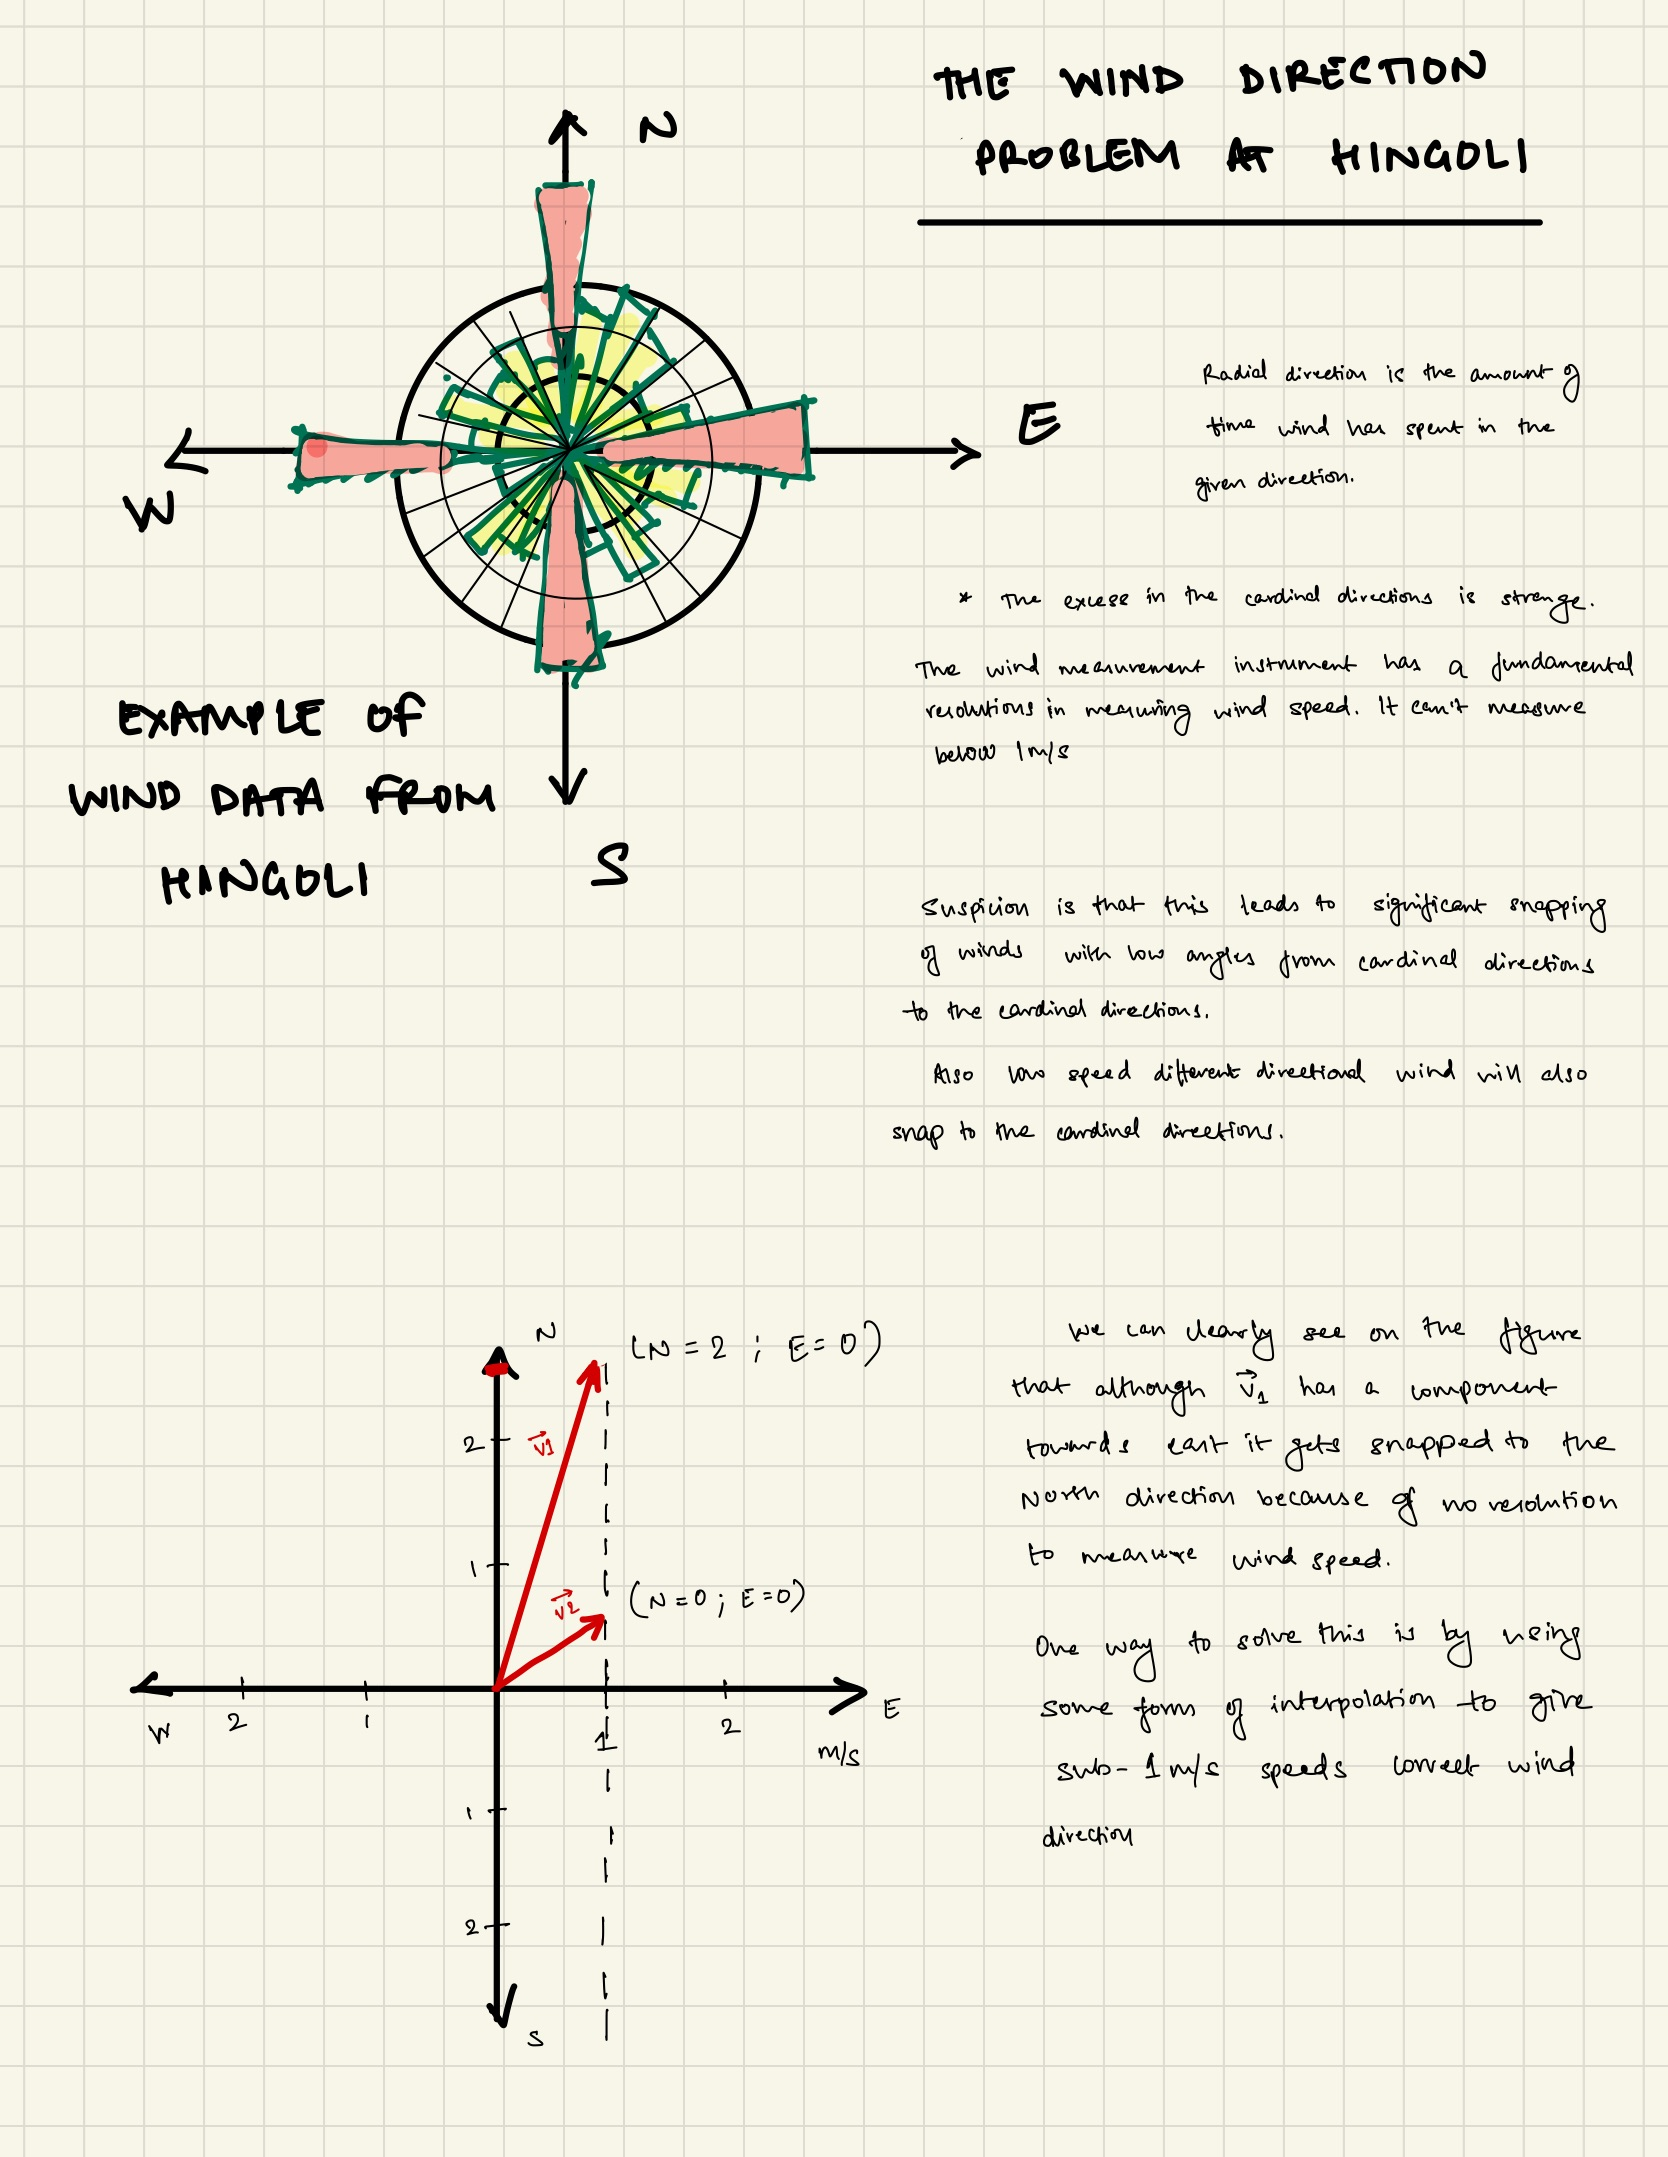

In [2]:
from IPython.display import Image
Image("wind_direction_problem_explainer.jpg")

In [4]:
import os, json, pickle, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
wind_data = pd.read_excel("weather_data_270622.xlsx")
wind_data2 = pd.read_excel("weather_data_100822.xlsx")

In [10]:
wind_data.columns = wind_data.iloc[0]

In [17]:
wind_data_columns = wind_data.columns
wind_data_units = wind_data.iloc[1]

In [22]:
wind_data = wind_data[2:].copy(deep=True)

In [30]:
wind_data.to_csv("weather_data_270622.csv", index=False)

In [15]:
wind_data2.to_csv("weather_data_100822.csv", index=False)

In [53]:
weather_data = pd.read_csv("weather_data_270622.csv")
weather_data.describe()

Temperature  Max Temperature  Min Temperature            RH  \
count  46352.000000     46352.000000     46352.000000  46352.000000   
mean      51.588294        51.640990        51.534058     74.609235   
std       32.789496        32.782257        32.800825     25.309611   
min        0.000000         0.000000         0.000000     18.850000   
25%       27.660000        27.680000        27.620000     53.600000   
50%       32.700000        32.750000        32.660000     79.800000   
75%      100.000000       100.000000       100.000000    100.000000   
max      100.000000       100.000000       100.000000    100.000000   

             Max RH        Min RH    Wind Speed  Max Wind Speed  \
count  46352.000000  46352.000000  46352.000000    46352.000000   
mean      74.717899     74.502739      3.408666        4.513486   
std       25.249923     25.367174      1.976712        2.459959   
min       18.970000     18.780000      0.000000        0.000000   
25%       53.800000     53.430000      1.900000        2.700000   
50%       79.940000     79.685000      3.200000        4.200000   
75%      100.000000    100.000000      4.600000        6.100000   
max      100.000000    100.000000     17.700000       21.500000   

       Wind Direction  Solar Radiation  Barometric Press.  Module Temp.  \
count    46352.000000     46352.000000       46352.000000  46352.000000   
mean       141.277831       234.122029         952.853630     32.122135   
std        127.298772       323.217853           1.924928      6.089149   
min          0.000000         0.000000         947.680000     21.470000   
25%         28.000000         0.000000         951.520000     27.550000   
50%         85.000000        22.400000         952.810000     31.180000   
75%        274.000000       424.400000         954.180000     36.092500   
max        359.000000      1307.700000         958.390000     60.000000   

               Rain  Battery Voltage  
count  46352.000000     46352.000000  
mean       0.003827        12.926562  
std        0.098978         0.387905  
min        0.000000        12.500000  
25%        0.000000        12.600000  
50%        0.000000        12.700000  
75%        0.000000        13.300000  
max       15.200000        13.800000

In [55]:
weather_data.tail(3)

Date      Time  Temperature  Max Temperature  \
46349  2022-06-27 00:00:00  16:48:00        30.51            30.65   
46350  2022-06-27 00:00:00  16:49:00        30.30            30.51   
46351  2022-06-27 00:00:00  16:49:00        30.30            30.51   

       Min Temperature     RH  Max RH  Min RH  Wind Speed  Max Wind Speed  \
46349            30.51  65.07   65.07   64.29         8.3             9.6   
46350            30.30  65.10   65.27   64.61         9.3            12.7   
46351            30.30  65.10   65.27   64.61         9.3            12.7   

       Wind Direction  Solar Radiation  Barometric Press.  Module Temp.  Rain  \
46349             279            159.6             950.27         32.33   0.0   
46350             279            148.1             950.24         31.92   0.0   
46351             279            148.1             950.24         31.92   0.0   

       Battery Voltage             GMT Time Unnamed: 17  
46349             13.3  2022-06-27 00:00:00    10:46:00  
46350             13.4  2022-06-27 00:00:00    10:46:00  
46351             13.4  2022-06-27 00:00:00    10:46:00

In [82]:
weather_data.columns

Index(['Date', 'Time', 'Temperature', 'Max Temperature', 'Min Temperature',
       'RH', 'Max RH', 'Min RH', 'Wind Speed', 'Max Wind Speed',
       'Wind Direction', 'Solar Radiation', 'Barometric Press.',
       'Module Temp.', 'Rain', 'Battery Voltage', 'GMT Time', 'Unnamed: 17'],
      dtype='object')

In [94]:
weather_data["time_time"] = pd.to_datetime(weather_data.Time)

In [44]:
weather_data.Date = pd.to_datetime(weather_data.Date)

In [ ]:
weather_data["time_units"] = weather_data.index

In [6]:
wind_direction = np.array(weather_data['Wind Direction'].copy(deep=True).tolist())

In [59]:
wind_speed = np.array(weather_data['Wind Speed'].copy(deep=True).tolist())

In [ ]:
wind_direction = np.array(weather_data)

### Plotting Utility

In [7]:
def plot_direction(y, y_unwrap=None, start=None, end=None, s=5, 
                   subset_keys=[], offset_start=0, num_ticks=75, plot_type='scatter'):
    
    plt.figure(figsize=(45,15))
    
    if type(y)==dict:
        start = 0 if start is None else start
        size = len(y[ list(y)[0] ])
        end = size if end is None else end
        
        x = np.arange(size)+offset_start
#         print(len(x))
        plots, plot_names = [], []
        subset_keys = subset_keys if subset_keys else list(y.keys())
        
        for k,v in y.items():
            if k in subset_keys:
                if plot_type=='scatter':
                    plots.append(plt.scatter(x[start:end], v[start:end], s=s))
                elif plot_type=='line':
                    plots.append(plt.plot(x[start:end], v[start:end], linewidth=s))
                plot_names.append(k)
            
        plt.legend(tuple(plots), tuple(plot_names), fontsize=10)
        x_ticks = np.linspace(x[start],x[end-1],min([num_ticks,size,end-start]))
        _ = plt.xticks(x_ticks)
        plt.xlabel('Time (minutes)')
        plt.ylabel('Degrees (period=360)')
        plt.xticks(rotation='vertical')
        plt.show()
    
    else:
        start = 0 if start is None else start
        size = len(y)
        end = size if end is None else end
        
        x = np.arange(size)+offset_start
        wrapped = plt.scatter(x[start:end], y[start:end], s = s, color='blue')

        if not y_unwrap is None:
            unwrapped = plt.scatter(x[start:end], y_unwrap[start:end], s = s, color='red')
            plt.legend(('wrapped', 'unwrapped'),(wrapped, unwrapped), fontsize=10)

        x_ticks = np.linspace(x[start],x[end-1],min(num_ticks,size))
        _ = plt.xticks(x_ticks)
        plt.xticks(rotation='vertical')
        plt.show()
        
    return

### Naive Unwrapping
Whenever the wind rotates about 0 degrees, meaning it may go from <360 to >0 or vice-verse, subtract 360 from it.  
This effectively maps the wind direction between -180, 180 degrees  
But this is a naive solution because when the wind crosses 180 degrees (or -180 degrees) we end up with the same phase wrapping problem  
Basically I've specifically solved only for cross overs between 0, 360   
    
     
This also doesn't solve the problem of wind rotating in one direction over a long time. What we rather want is for the phase to keep monotonically evolving until the wind direction keeps evolving in the same direction.  
For this I refer to the following reference sent by Suresh : https://www.ljmu.ac.uk/~/media/files/ljmu/about-us/faculties-and-schools/fet/geri/onedimensionalphaseunwrapping_finalpdf.pdf

In [12]:
naive_unwrap = lambda x : [angle if angle<=180 else angle-360 for angle in x]
plt.figure(figsize=(45,15))

plt.scatter(weather_data.index.tolist(), naive_unwrap(weather_data['Wind Direction'].tolist()), s = 1, color='red')
plt.scatter(weather_data.index.tolist(), weather_data['Wind Direction'].tolist(), s = 1)

In [14]:
wind_direction2 = np.mean(get_segments(wind_direction, 10, noverlap=0), axis=-1)

out = {"wrapped":wind_direction2, "unwrapped":naive_unwrap(wind_direction2)}
plot_direction(out, subset_keys=['unwrapped'], s=1, plot_type='line', num_ticks=500, offset_start=0)

In [15]:
wind_direction2 = np.mean(get_segments(wind_direction, 10, noverlap=0), axis=-1)

out2 = {"wrapped":wind_direction, "unwrapped":naive_unwrap(wind_direction)}
plot_direction(out2, subset_keys=['unwrapped'], s=1, plot_type='line', num_ticks=500, offset_start=0)

In [16]:
plot_direction(out2, subset_keys=['wrapped'], s=1, plot_type='line', num_ticks=500, offset_start=0)

### Phase Unwrapping v1
To allow monotonicity when wind direction changes in the same direction I am coming up with the following formula -    
1. When the angle difference (diff) between 2 neighboring points a1, a2 (diff = a2-a1 < -359) it implies a cross over from 360 to 0, so we will add 360 to every data point beyond a2 including a2  
2. When the diff = a2-a1 > 359, it implies a cross over from 0 to 360, so we will subtract 360 from every data point beyond a2 including a2  

In [120]:
def phase_unwrap_v1(angles):
    angles.append(angles[-1])
    norm_angles = []
    offset = 0 
    
    for i in range(len(angles)-1):
        cur, nxt = angles[i], angles[i+1]
        norm_angles.append(cur+offset)
        if nxt-cur<=-359:
            offset+=360
        elif nxt-cur>=359:
            offset-=360
            
    return norm_angles

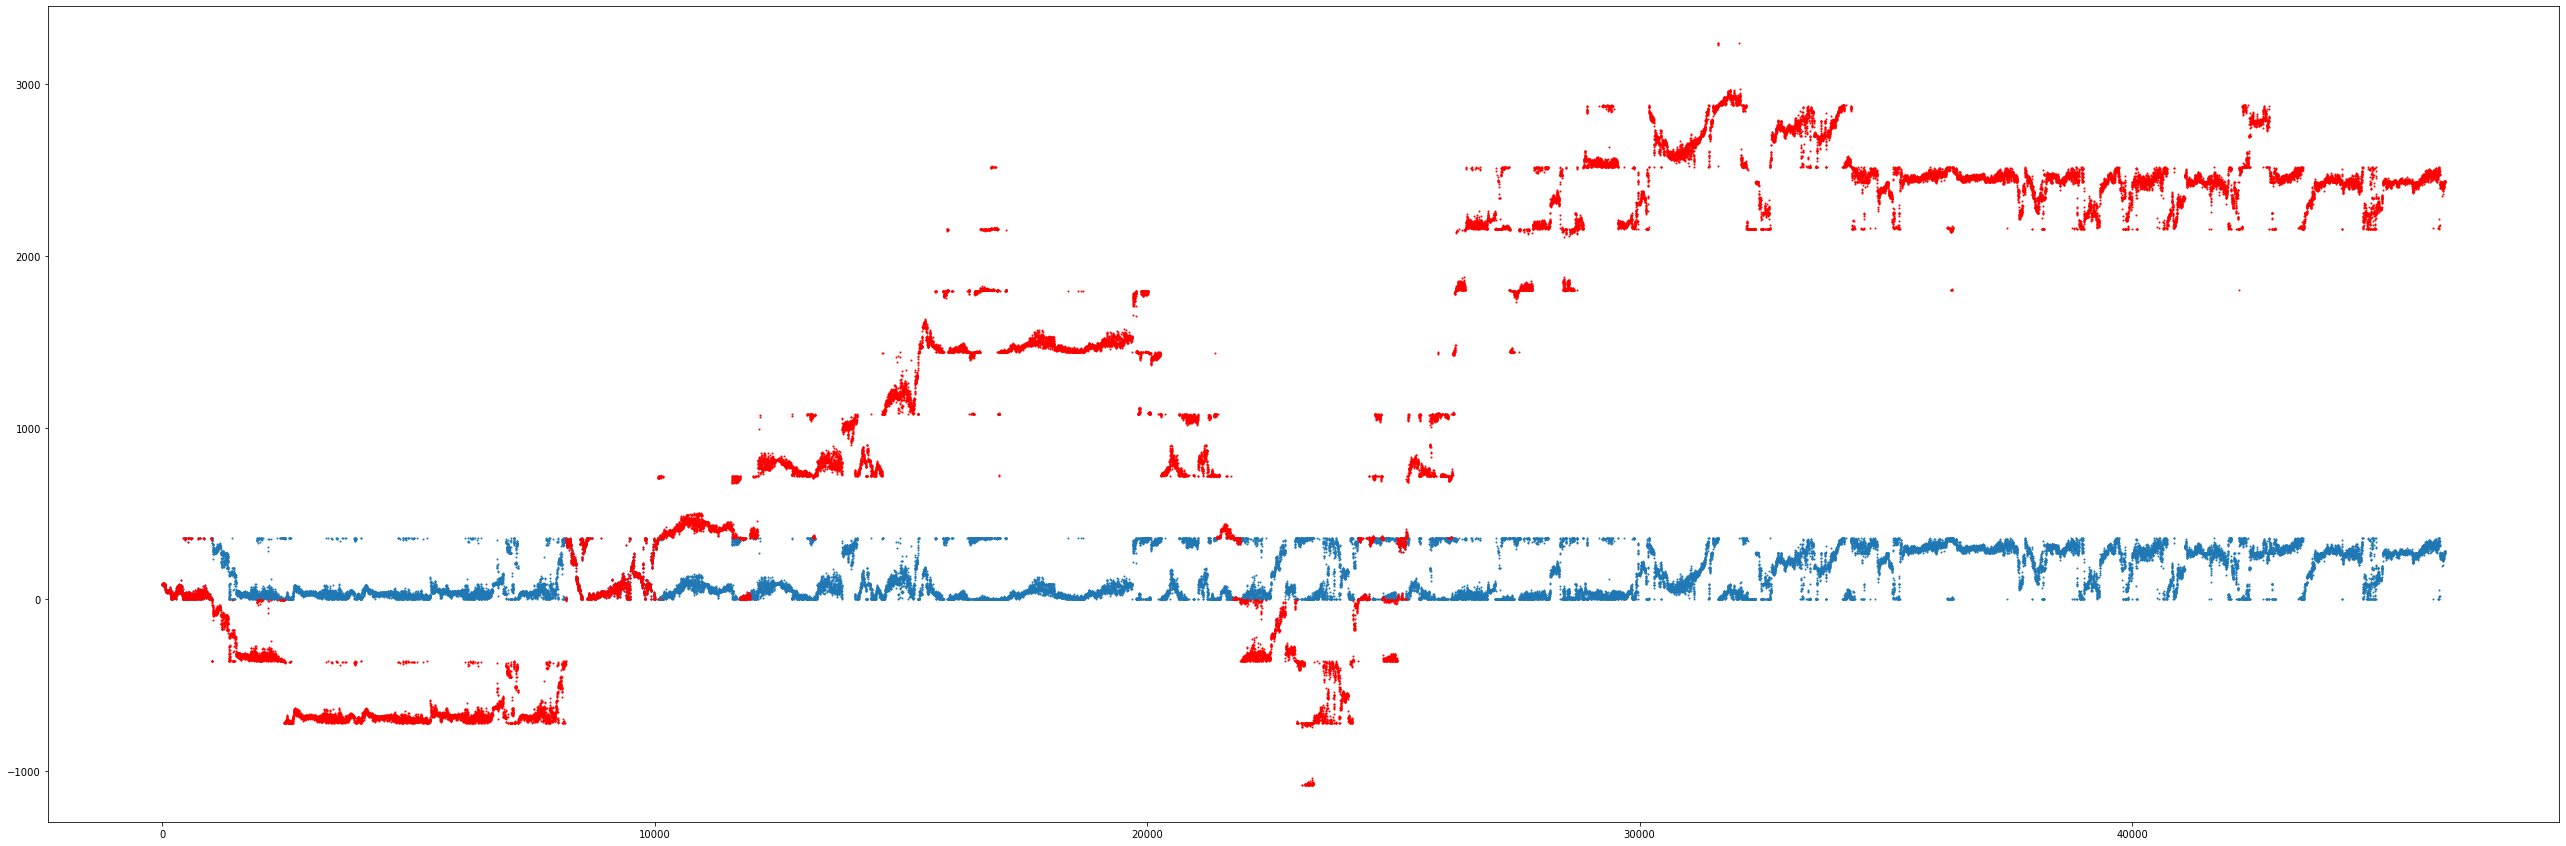

In [121]:
plt.figure(figsize=(45,15))

plt.scatter(weather_data.index.tolist(), weather_data['Wind Direction'].tolist(), s = 1)
v1_unwrap = phase_unwrap_v1(weather_data['Wind Direction'].copy(deep=True).tolist())
plt.scatter(weather_data.index.tolist(), v1_unwrap, s = 1, color='red')

### Phase Unwrapping v2
In the previous method the assumption was that wind direction will continuously evolve with max diff of 1 between current and previous point which is obviously wrong. Meaning if a2 is 350 and a1 is 10 (meaning the wind direction suddenly changed by 20 degrees and made a cross over), then a2-a1 = 340 which is not greater than 359, so the offset won't be applied.  
One way to fix this is to allow for a larger margin when doing offsets. In v1 method the margin was 1, if we set out threshold to 340 instead of 359 I think we may get better behavious. Assumption should be that angles can't change drastically in a short time because we assume some sane continuity behaviour in the wind directions over time.  
Applying manual thresholds is not always good and doesn't generalize well. Also it will screw up for cases where wind dirction actually drastically changes angles >340. This may also happen because resolution of data is 1/minute, and quite likely that wind changes direction significantly over a minutes's time.  
  
Nevertheless, applying a threshold of 340 now to the following method.

In [186]:
def phase_unwrap_v2(angles, threshold=350):
    angles.append(angles[-1])
    norm_angles = []
    offset = 0 
    
    for i in range(len(angles)-1):
        cur, nxt = angles[i], angles[i+1]
        norm_angles.append(cur+offset)
        if nxt-cur<=-threshold:
            offset+=360
        elif nxt-cur>=threshold:
            offset-=360
            
    return norm_angles

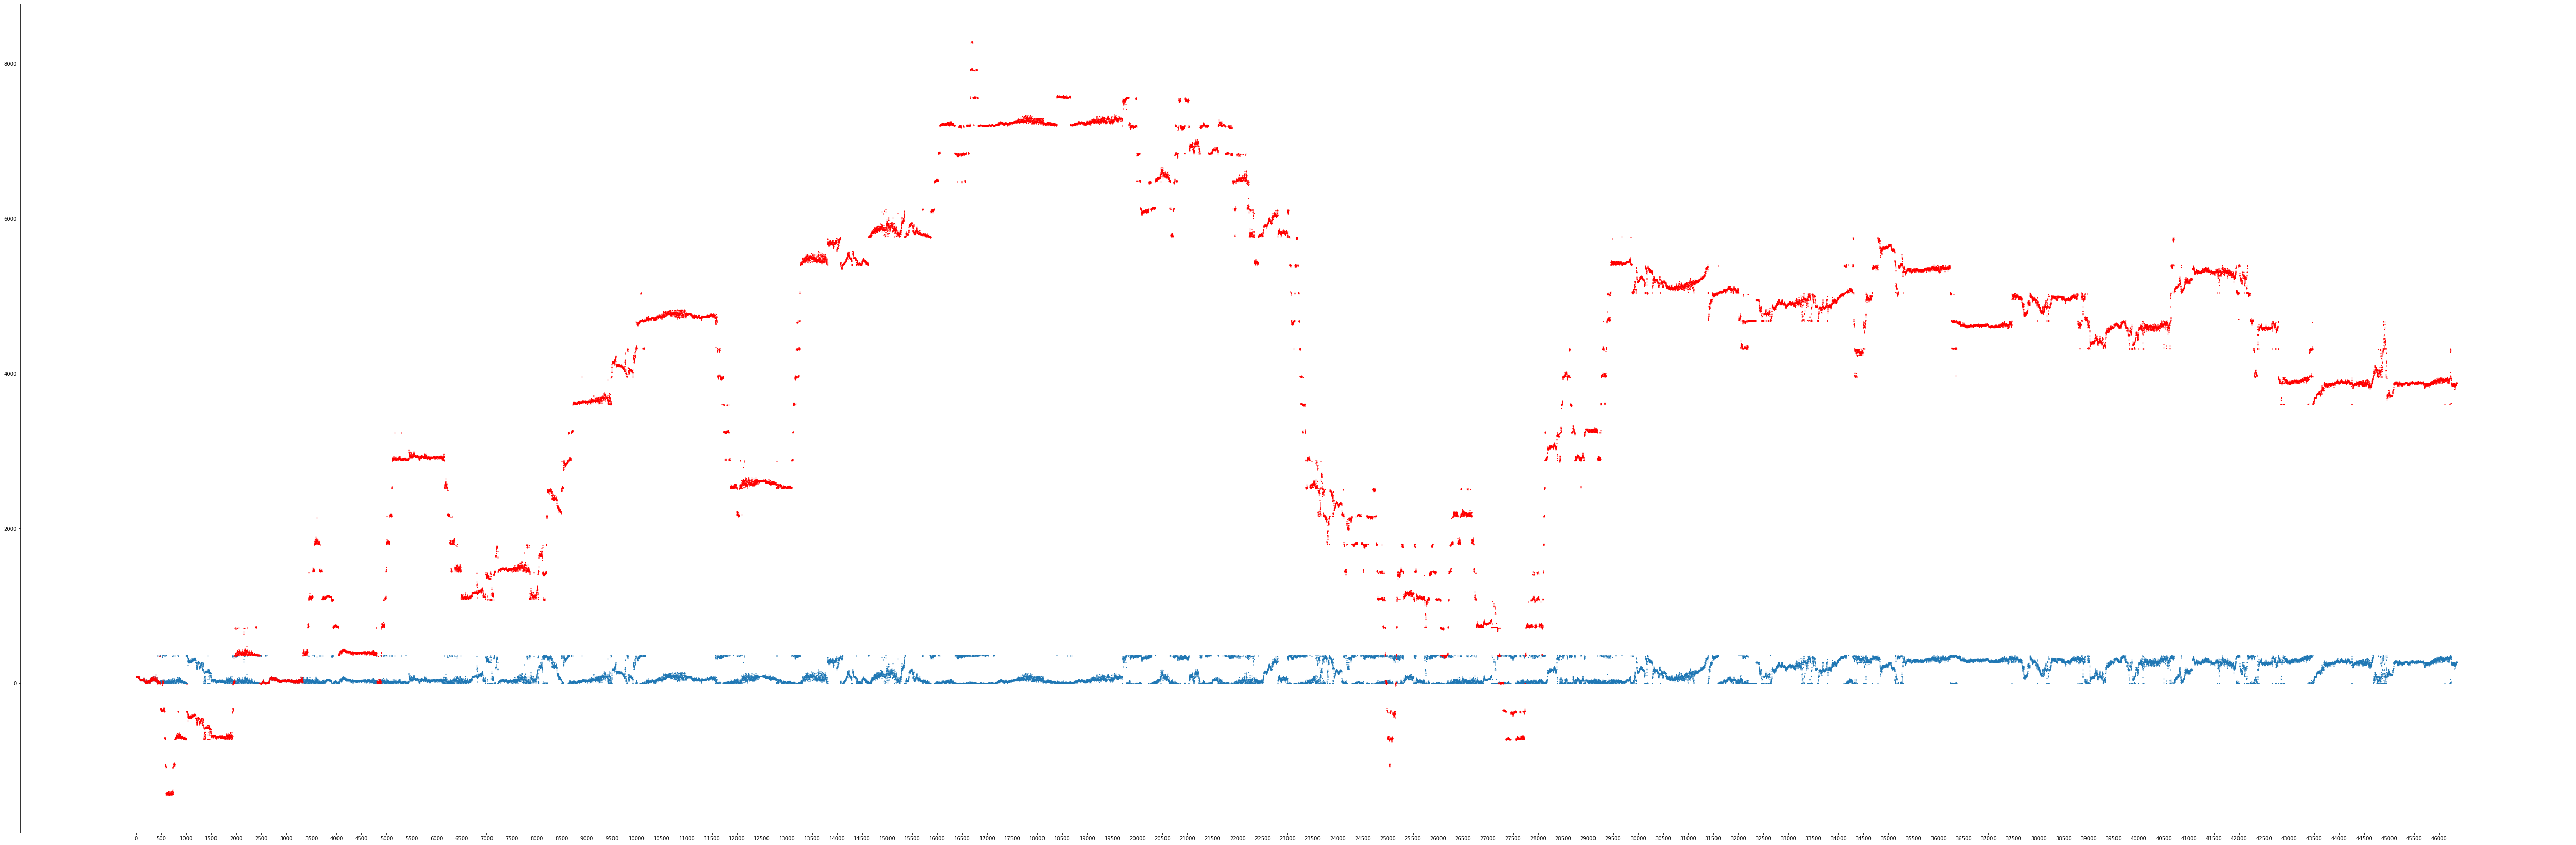

In [187]:
plt.figure(figsize=(90,30))

plt.scatter(weather_data.index.tolist(), weather_data['Wind Direction'].tolist(), s = 1)
v2_unwrap = phase_unwrap_v2(weather_data['Wind Direction'].copy(deep=True).tolist())
plt.scatter(weather_data.index.tolist(), v2_unwrap, s = 1, color='red')
_ = plt.xticks(np.arange(0,weather_data.shape[0],500))

### Phase Unwrap v3
This is the moment to realise that phase unwrapping is definitely not a straightforward problem to solve. Due to the following reasons   
1. Even after using multiple different thresholds to disallow noise in the data from giving false offset jumps they still creep in  
2. Realized that one wrong unwrap will screw up entire future data from the screw up point, so precision has to be 100%  
3. There are systematic jumps during unwrapping becasue the phase diff between adjacent points is unable to get passed through the fixed offset threshold  
  
The idea for v3 of phase unwrapping is to use some kind of adaptive thresholding that can look around in the neighborhood and decide dynamically if a phase change has occurred or not. One simple idea to do this is to find the mean and variance of the n neighboring data points. Whenever we find **high variance**, it may imply that at least some of the data points are very widely spaced which may imply a phase wrap is happening. Moreover the evolution of mean and variance will help us understand at which exact data point the **variance jumps**. Also during a phase wrap the **mean as well as variance will jump** from the previous value.   
Some plots below to support the above idea   
1. First plot is of 5 data point segments mean plotted with original data  
    a. Clearly see 5 bands in between these are when the window is going through a phase shift as some points are close to 360 and some points are close to 0 we see bands at nx360/5 ~ nx70  
    b. Although at some places like towards left-most, the mean is high without phase wrap, it evolves continuously, meaning mean2-mean1 difference is less as compared to what we may see from a phase wrap jump  
2. Second plot is of 5 data point segments std plotted with original data  
    a. std is high for phase jumps  
    b. Sometimes std is high withough phasse jumps in between, but the difference should tell us if a jump has occurred or is it continuous evolution  
3. Third plot is the difference of means from their adjacent means. As expected most means cluster around 0 except some that are high and flank around +60 to -60 which most likely describe a phase wrap    
4. Fourth plot is the difference of std from their adjacent std. Again most stds cluster around 0, interestingly I see 2 prominent bands that flank the mean 0 std   
    The very interesting reason why this may be happening is as follows - if neatly observed the data points in the bands occur only when there are also some data points at maximum variance. When the segment window encounters a phase wrap for the first time, the variance would suddenly peak. As the window moves ahead the variance will slowly decrease as more same phase points are added and less previous phase points remain. If the wind direction really evolved smoothly, most likely at every phase wrap there should be similar distribution of neighbors, which implies similar evolution of std over when the window passes over those neighbors. So the bands are most likely because immediately after a phase wrap the variance of new window is adjusting to the new neighbors distribution.   
    If observed properly, there is a even smaller band closer to 0. Hints at successive reduction of variance as the window moves.  
    
From observing the data the mean jumps at phase wrap ~30, the std jumps at phase wrap ~50  

  
One more idea is to use ANOVA between the 2 samples with a threshold on p-value to check if the 2 distributions are similar. 

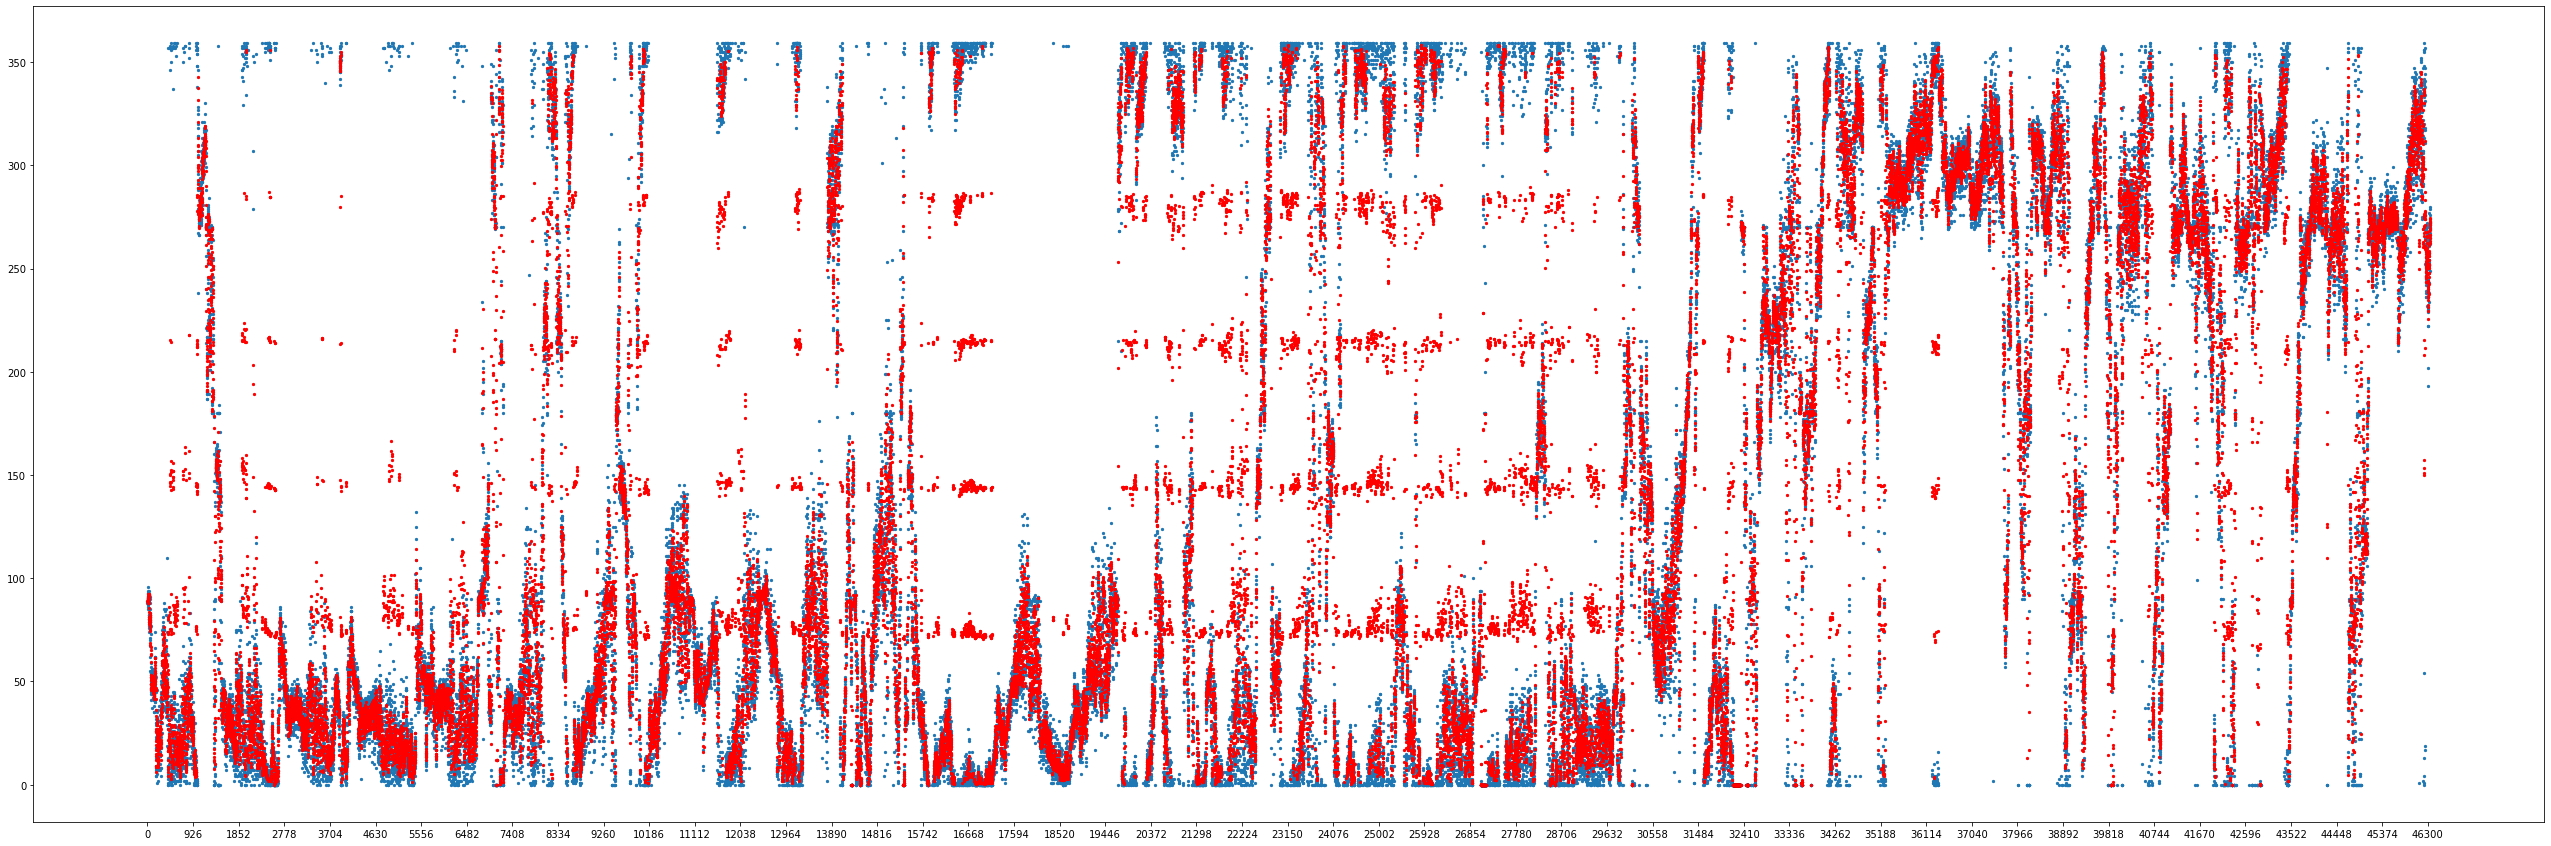

In [212]:
Image("mean_5neighbors.png")

In [ ]:
[f f f f f f f w w w f f f f f f f]
[x x x x x]
  [y y y y y]
    [z z z z z]
    
y_mean - x_mean
y_var - x_var

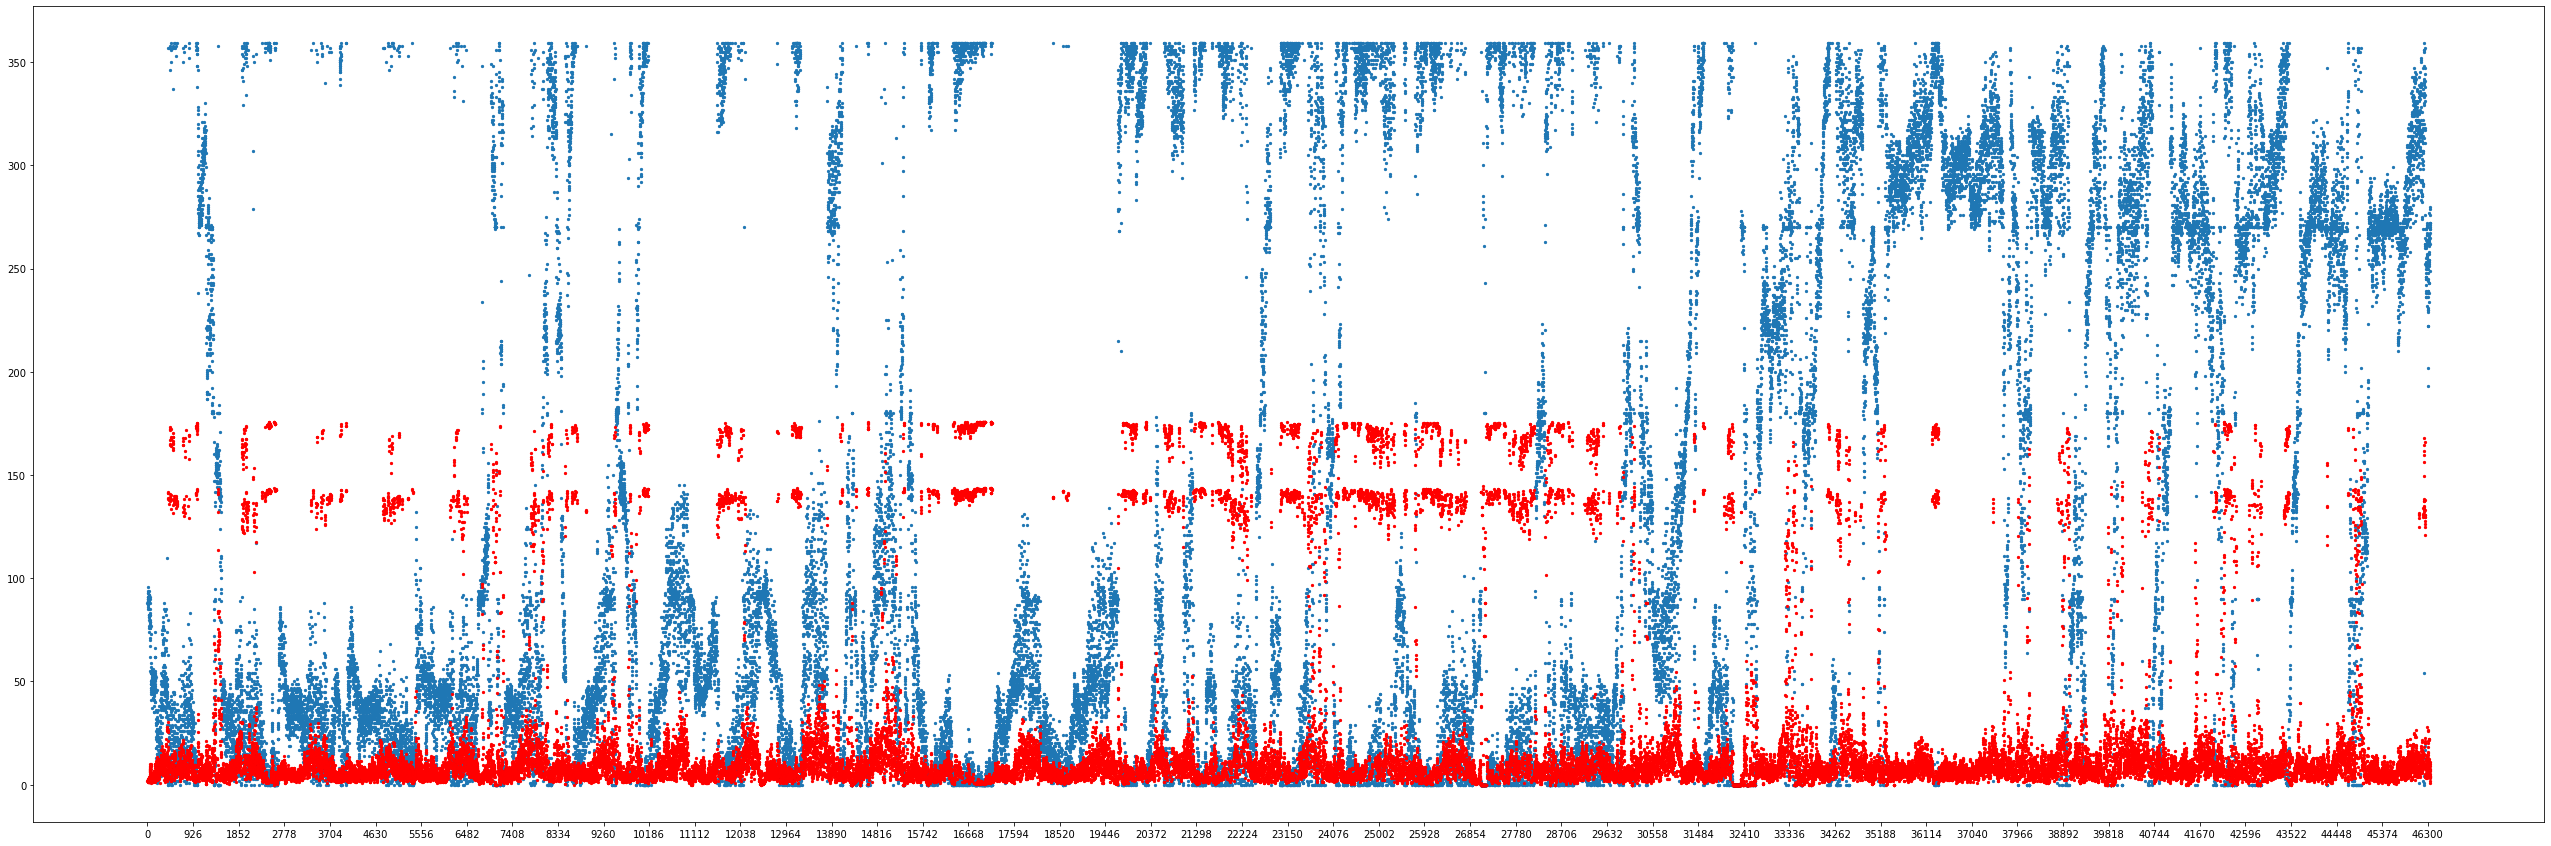

In [213]:
Image("std_5neighbors.png")

In [219]:
segs = get_segments(wind_direction, 6)
m, v = np.mean(segs, axis=-1), np.std(segs, axis=-1)
m = m[1:]-m[:-1]
v = v[1:]-v[:-1]

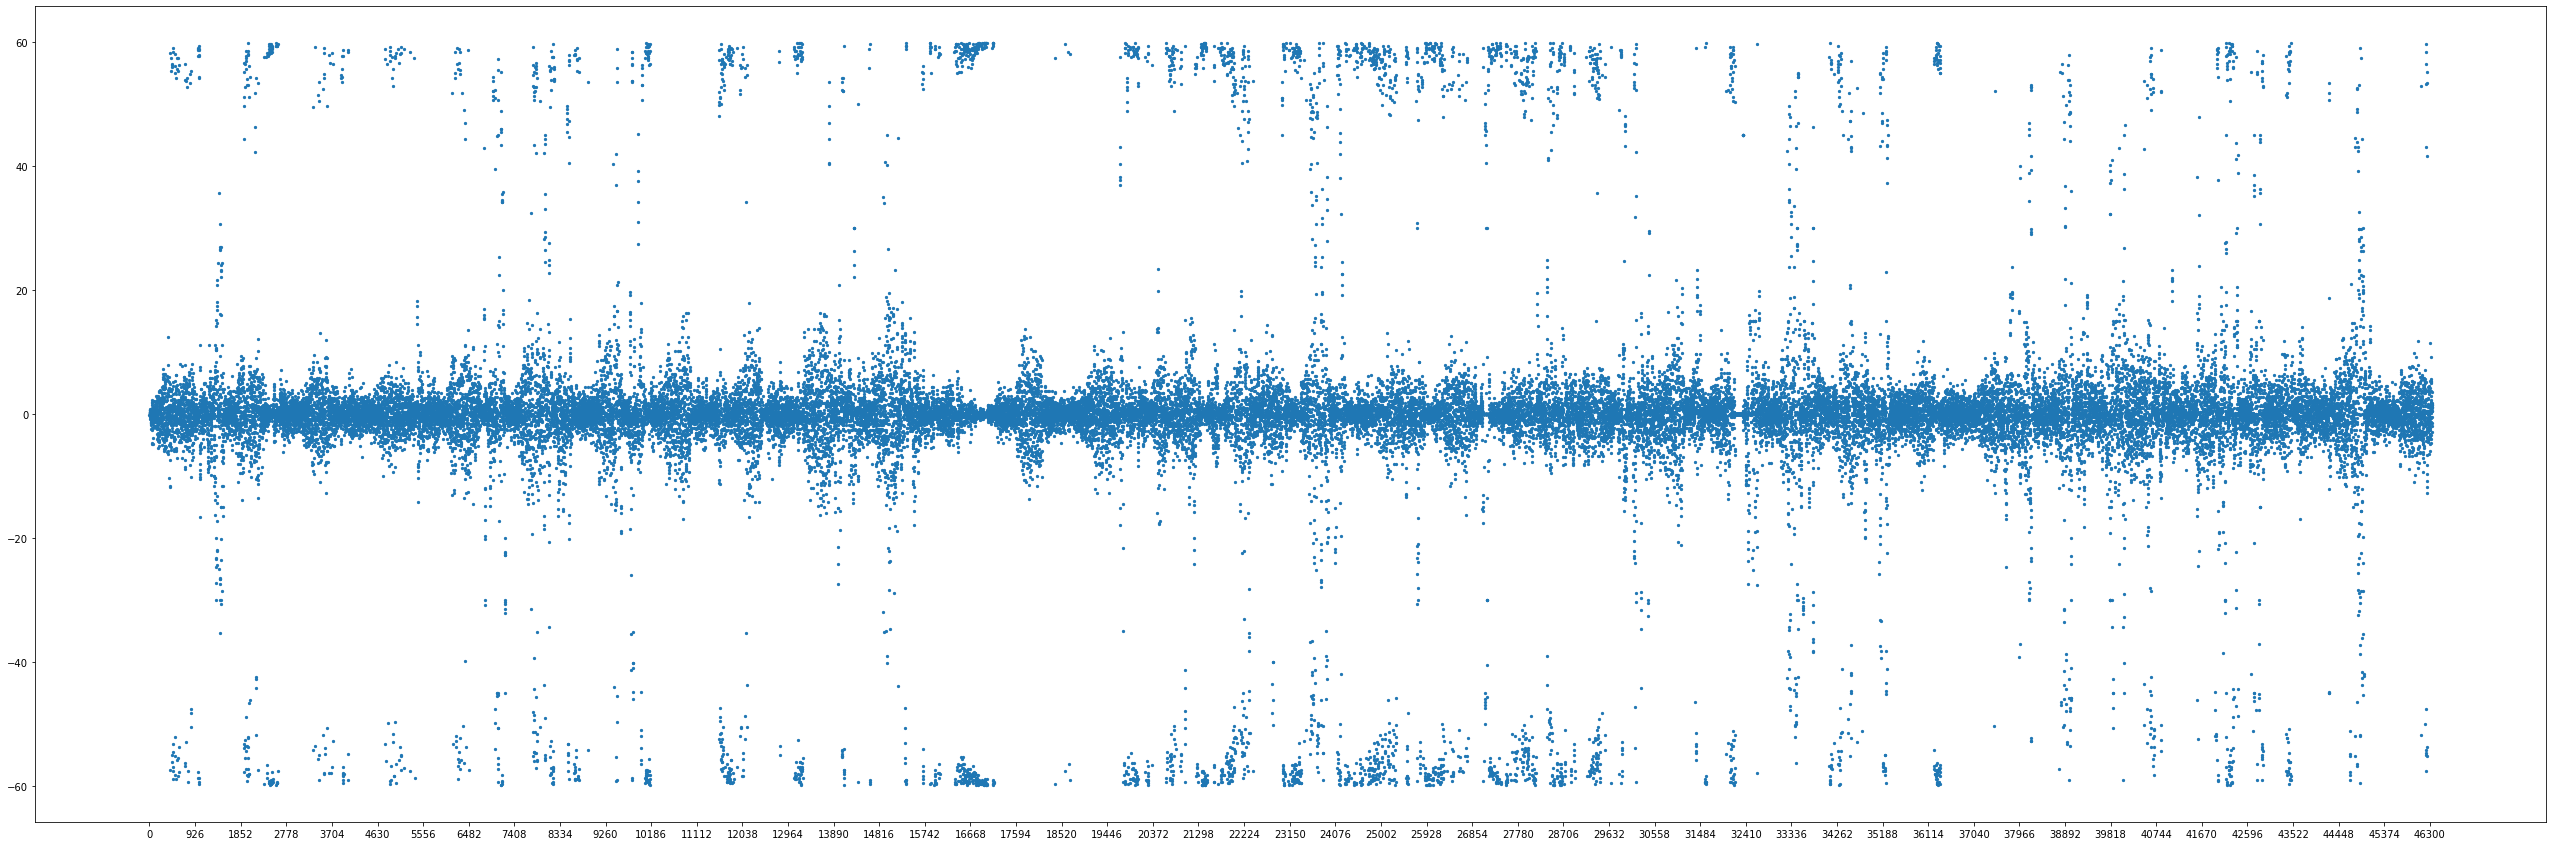

In [220]:
plot_direction(m)

In [287]:
np.std(m), np.std(v)

(16.03057286624475, 20.20931487943681)

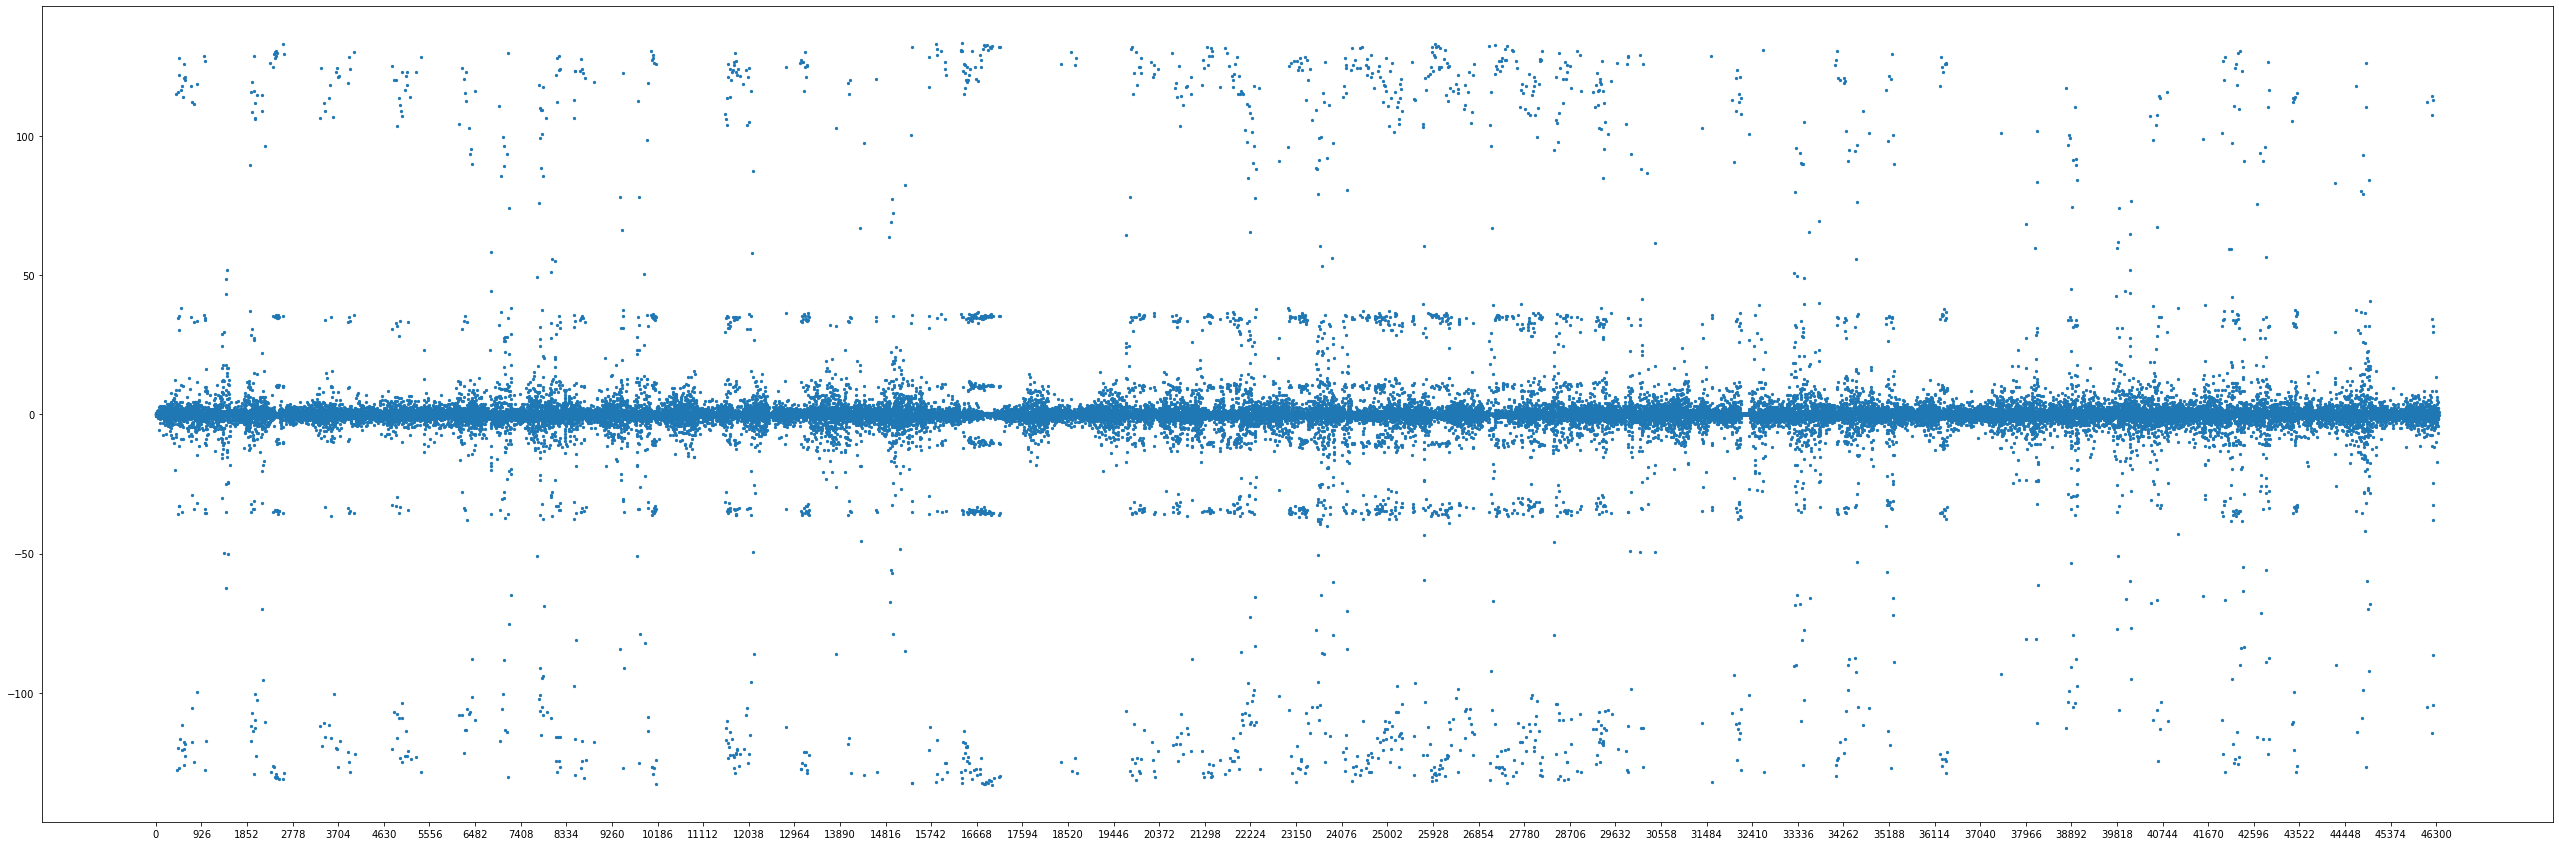

In [221]:
plot_direction(v)

In [270]:
get_segments = lambda data, N : np.array([data[k:k+N] for k in range(len(data)-N+1)])

def phase_unwrap_v3(data, nperseg=6, threshold_mean=30, threshold_std=50):
    
    segments = get_segments(data, nperseg)
    segmean, segvar = np.mean(segments, axis=-1), np.std(segments, axis=-1)
    mean_diff, std_diff = segmean[1:]-segmean[:-1], segvar[1:]-segvar[:-1]
    
    data = data.copy()[nperseg//2:-nperseg//2+1]
    data_diff = data[1:]-data[:-1]
    
    unwrapped = []
    offset = 0
    
    for i in range(len(data)-1):
        
        unwrapped.append(data[i]+offset)
        if (mean_diff[i]>threshold_mean and std_diff[i]>threshold_std):
            offset-=360
        elif (mean_diff[i]<-threshold_mean and std_diff[i]<-threshold_std):
            offset+=360
        
    return np.array(unwrapped)

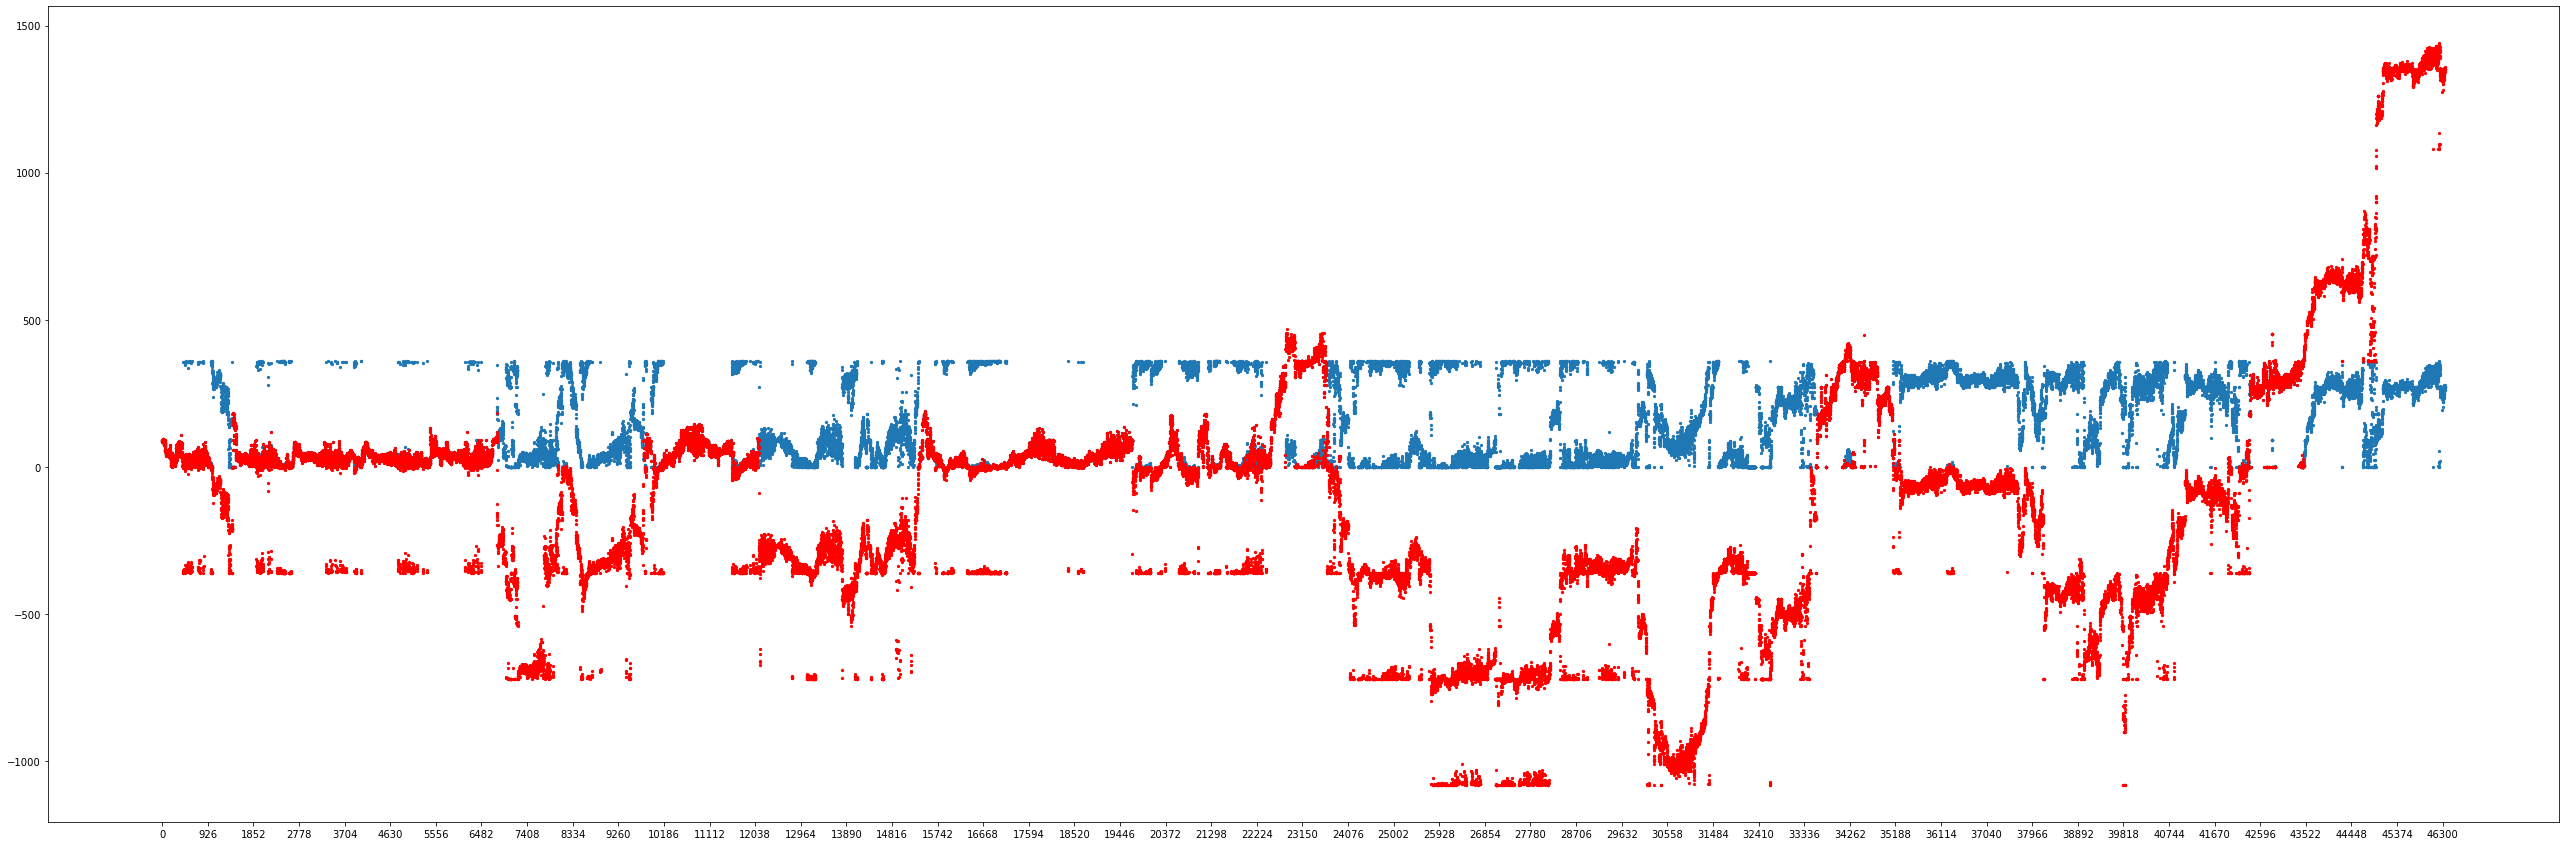

In [273]:
v3_unwrap = phase_unwrap_v3(wind_direction)
plot_direction(wind_direction[3:-3], v3_unwrap)

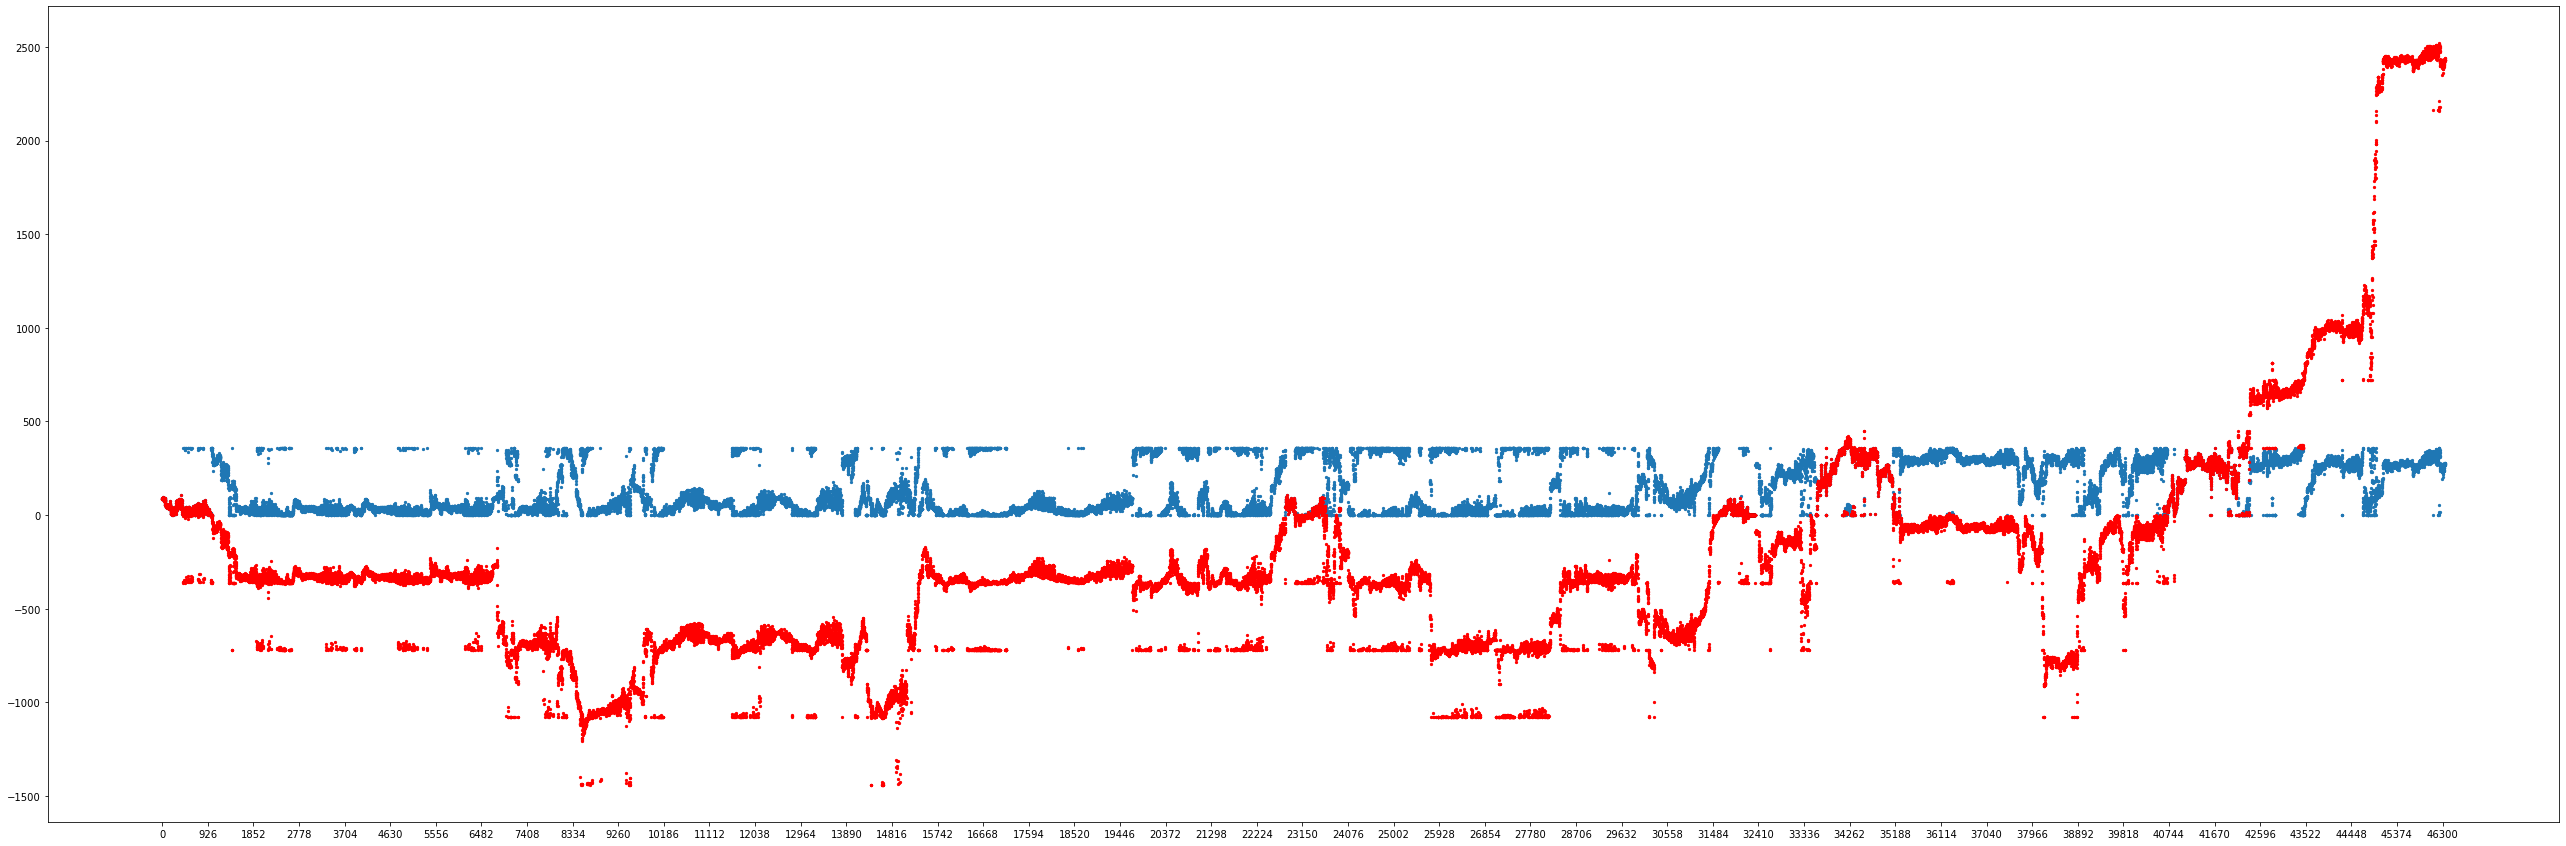

In [277]:
v3_unwrap = phase_unwrap_v3(wind_direction, nperseg=4)
plot_direction(wind_direction[2:-2], v3_unwrap)

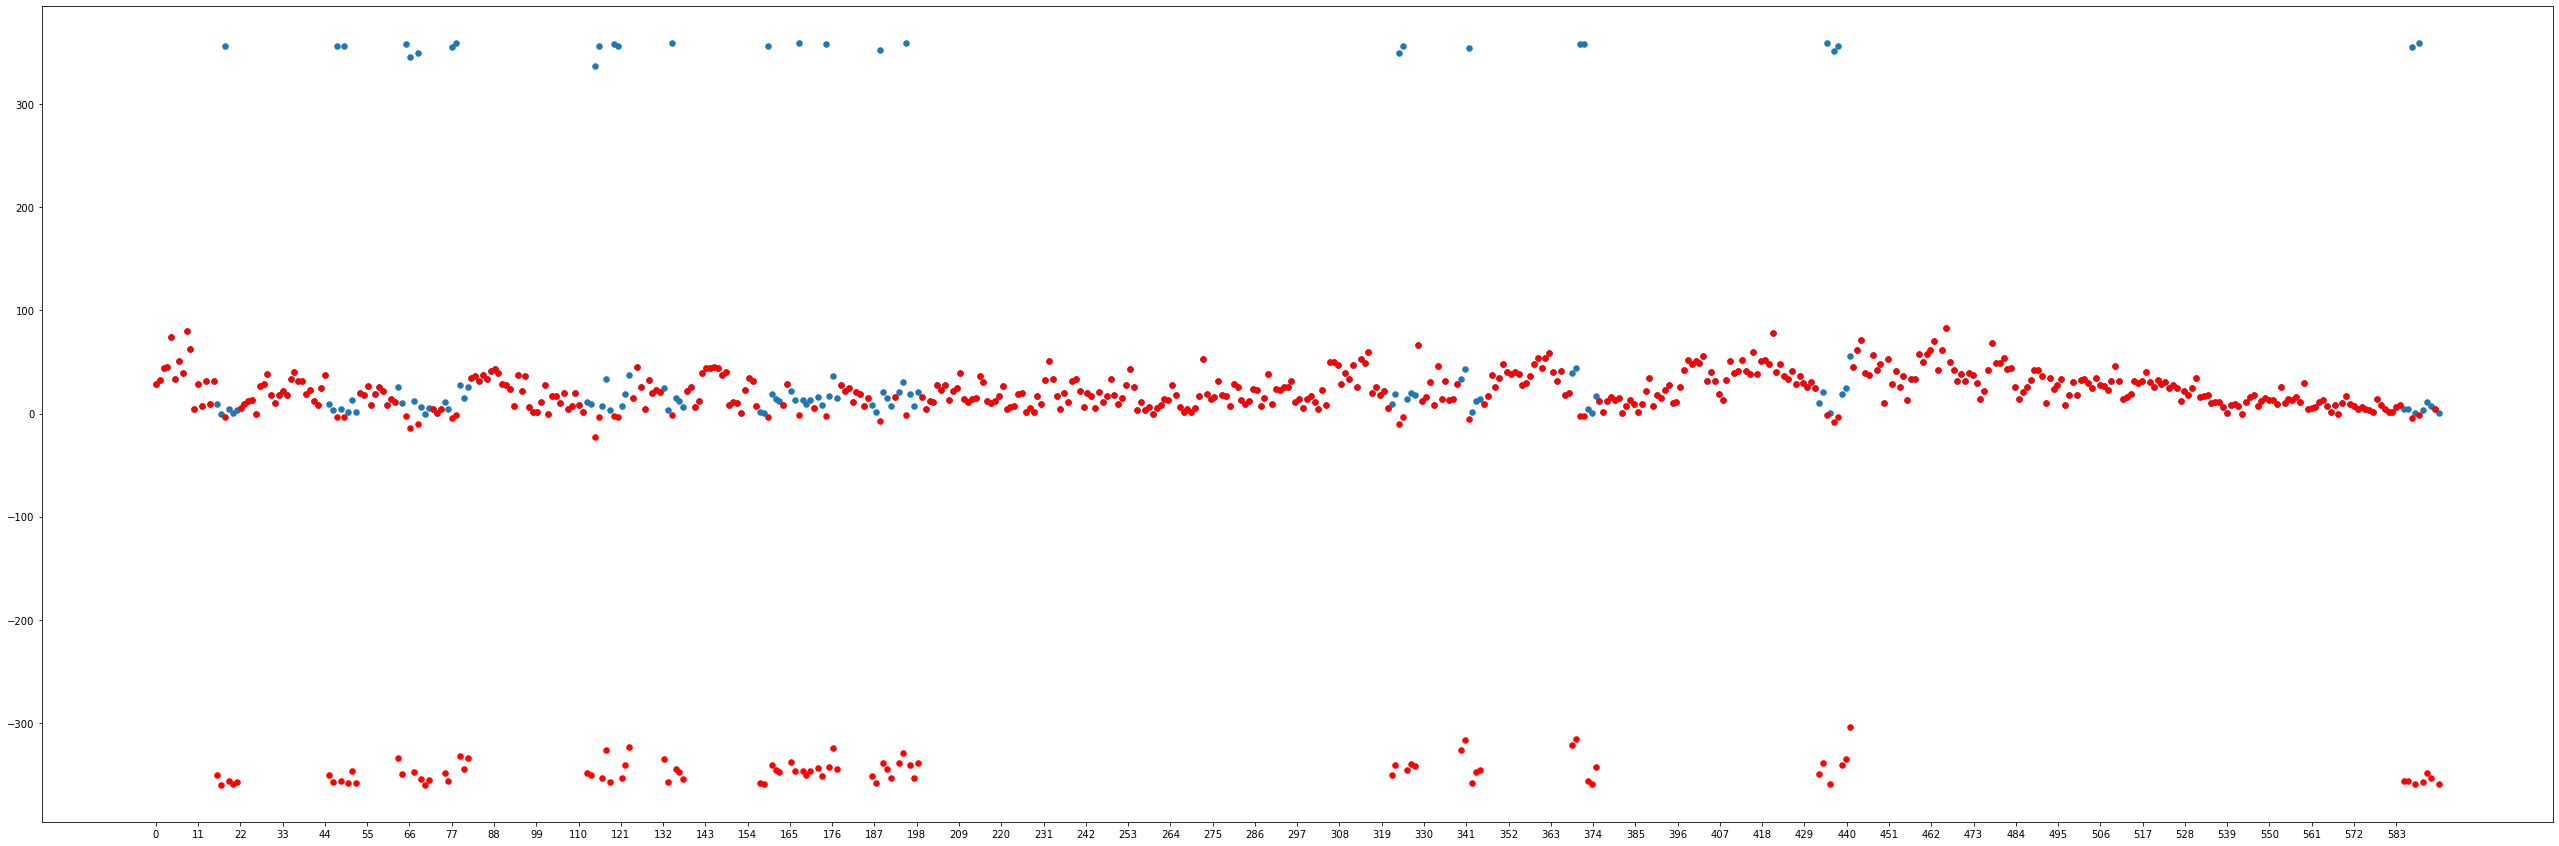

In [251]:
nperseg = 6
wd = wind_direction[400:1000]
wduw = phase_unwrap_v3(wd, threshold_mean=30, threshold_std=50)
plot_direction(wd[nperseg//2:-nperseg//2], wduw, s=30)

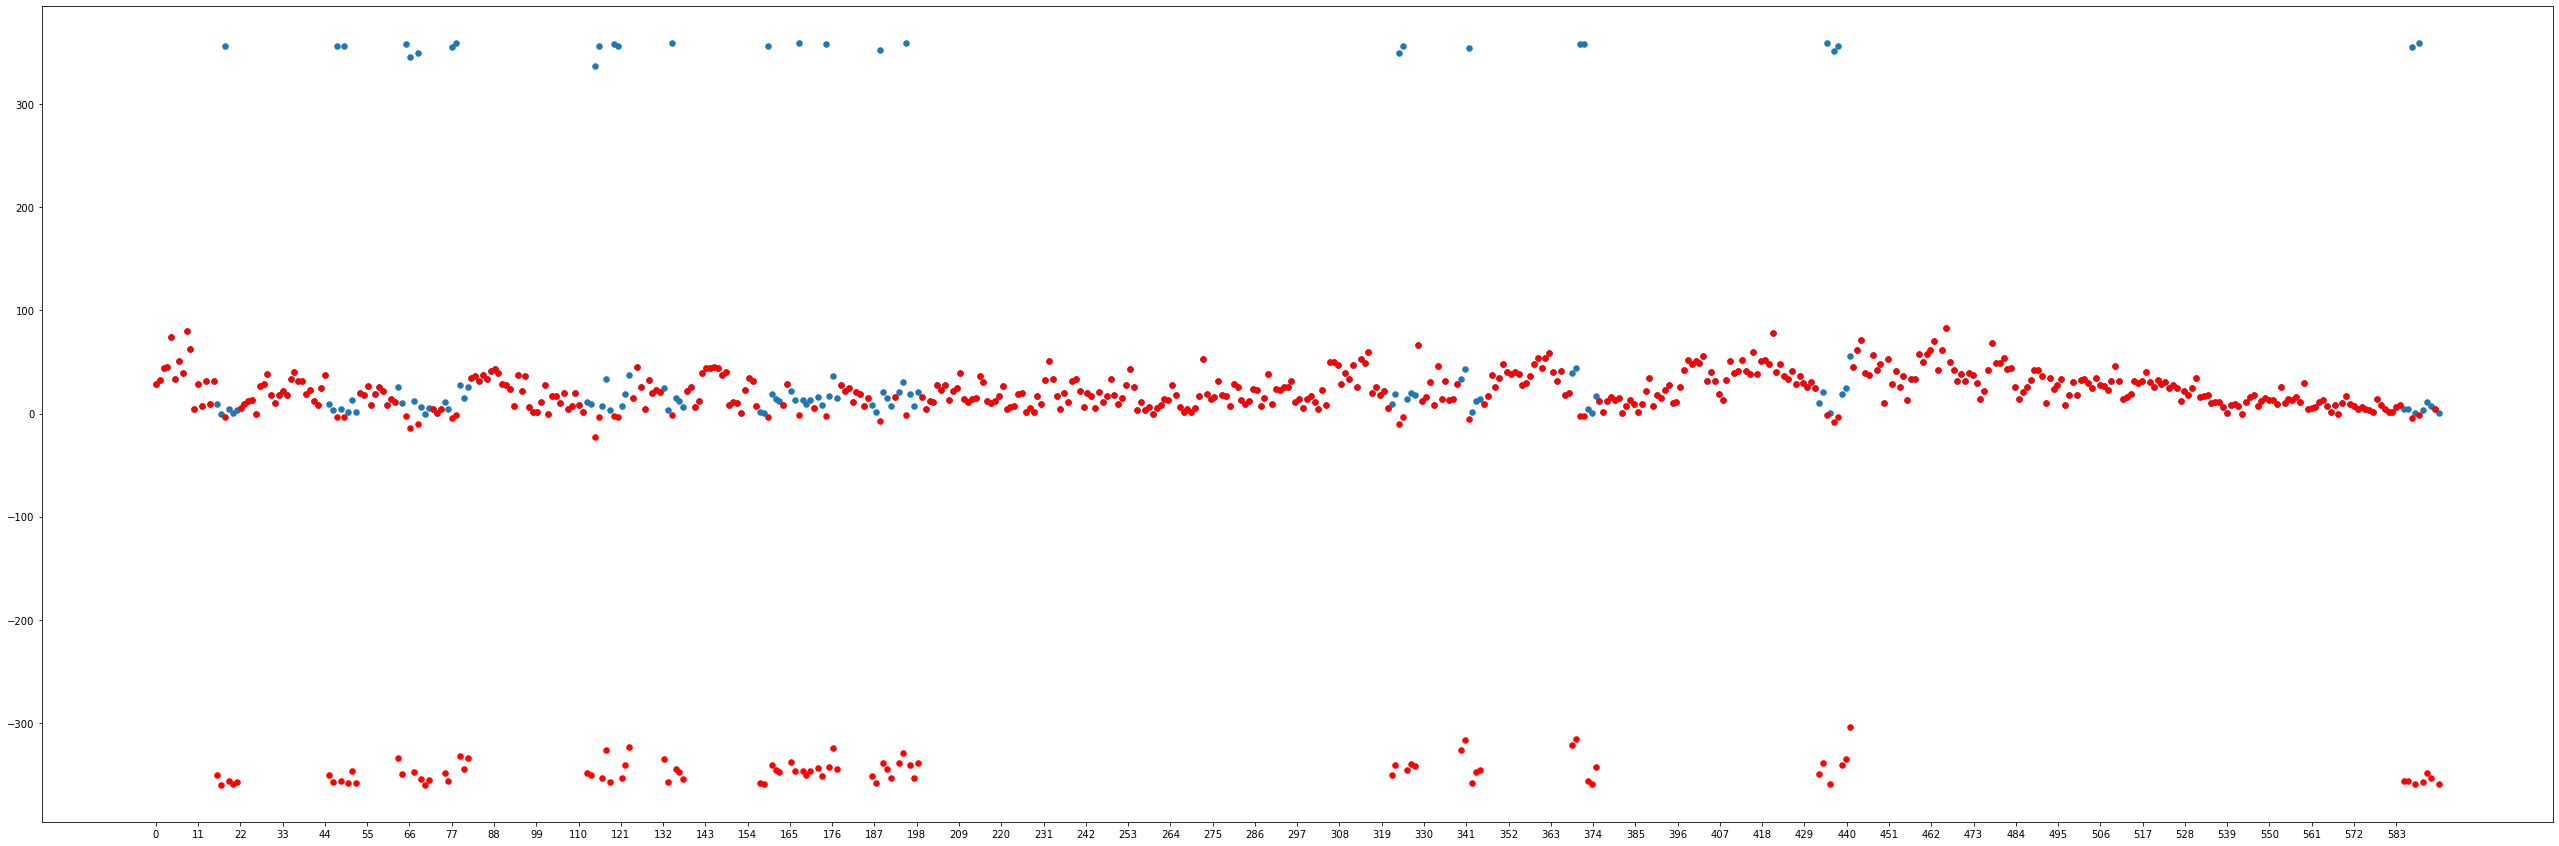

In [263]:
wduw = phase_unwrap_v3(wd, threshold_mean=40, threshold_std=65)
plot_direction(wd[nperseg//2:-nperseg//2], wduw, s=30)

### Phase Unwrap v3.1
Unwrapping with semi-adaptive thresholding look promising on longer chunks of data. Following benefits are evident  
1. This method is more robust to noisy data and heavily fluctuating data (heavy fluctuations may happen due to low sampling rate) - this is evident from much lesser number of disconnected jumps in the wind direction evolution  
  
It is difficult to say what window size suits best; lesser window size creates smaller groups of discontinuous points from first cut analysis. Does larger window size have any benefits? Need to investigate.  
Two clear problems with this method as as follows -   
1. Thresholds are not completely adaptive - I am still putting manual thresholds on mean and variance  
2. When the wind changes directions a lot around 0/360 mark I always see clusters of discontinuous points created by this method - example is plot above - this happens because even if a single point is phase wrapped the mean and variance jumps for the entire window length, until the point is out of the window. This makes the other nperseg-1 points to undergo a spurious offset which they shouldn't have been subjected to   
   
   
   
I am planning the following updates to the above method -  
1. Fully adaptive thresholding - this will compute the std in mean_diff & std_diff arrays and specify threshold as Kx of the std found. This is like saying anything beyond K-sigma distance of my mean is an outlier; this removes the need for manual thresholding    
2. Additional condition on difference in neighboring points to fix for jitter across the 0/360 degree mark which is screwing up the mean and variance based decision. I will use this extra diff to check if a offset is necessary or not as I am observing that close to these jitters additional offset values are created which are spurious leading to discontinuities.  
3. Making period a parameter since for some other dataset it may not be 360  

In [56]:
validate_lengths = lambda data_list : len(list(set( [len(x) for x in data_list] )))==1


def get_segments(data, N, noverlap=None):
    
    if noverlap is None:
        return np.array([data[k:k+N] for k in range(len(data)-N+1)])

    elif noverlap>N:
        raise Exception("noverlap cannot be larger than N")

    return np.array([data[k:k+N] for k in range(0,len(data)-N+1,N-noverlap)])


def phase_unwrap_v3dot1(data, nperseg=6, period=360, k1=1.87, k2=2.47, k_s=0.25):
    
    # k1.sigma1, k2.sigma2 will be considered outlier for mean and var respectively
    
    segments = get_segments(data, nperseg)
    segmean, segvar = np.mean(segments, axis=-1), np.std(segments, axis=-1)
    mean_diff, std_diff = segmean[1:]-segmean[:-1], segvar[1:]-segvar[:-1]
    
    threshold_mean, threshold_std = np.std(mean_diff)*k1, np.std(std_diff)*k2
    
    data = data.copy()[nperseg//2:-nperseg//2+1]
    data_diff = data[1:]-data[:-1]
    
    unwrapped = []
    prev_offset, cur_offset = 0, 0
    
    for i in range(len(data)-1):
        
        if i>20 and abs(np.mean(unwrapped[-20:])-(data[i]+prev_offset))>=k_s*period:
            unwrapped.append(data[i]+cur_offset)
        else:
            unwrapped.append(data[i]+prev_offset)
            
        if (mean_diff[i]>threshold_mean and std_diff[i]>threshold_std):
            prev_offset = cur_offset
            cur_offset-=360
#             offset-=360
            
        elif (mean_diff[i]<-threshold_mean and std_diff[i]<-threshold_std):
            prev_offset = cur_offset
            cur_offset+=360
#             offset+=360
        
    output_dict = {
        'wrapped' : np.array(data[:-1]),
        'unwrapped' : np.array(unwrapped),
        'mean_diff' : np.array(mean_diff),
        'std_diff' : np.array(std_diff),
        'data_diff' : np.array(data_diff)
    }
    
    output_list = [v for k,v in output_dict.items()]
    
    if not validate_lengths(output_list):
        print({k:len(v) for k,v in output_dict.items()})
        raise Exception("Len of output lists don't match")
        
    return output_dict

In [80]:
wind_direction_persisted = []
for i in range(len(wind_speed)):
    if wind_speed[i]>0:
        wind_direction_persisted.append(wind_direction[i])
    else:
        wind_direction_persisted.append(wind_direction_persisted[-1])
        
wind_direction_persisted = np.array(wind_direction_persisted)

In [84]:
import warnings
warnings.simplefilter("ignore")
config = {
    'period' : 360,
    'nperseg' : 4,
    'k1' : 2,
    'k2' : 2.5,
    'k_s' : 0.25
}
wind_direction2 = np.mean(get_segments(wind_direction, 2, noverlap=0), axis=-1)
v3dot1_unwrap = phase_unwrap_v3dot1(wind_direction, **config)
#v3dot1_unwrap = phase_unwrap_v3dot1(wind_direction_persisted, **config)

start, end = 0, len(v3dot1_unwrap['wrapped'])
v3dot1_unwrap_ = {k:v[start:end] for k,v in v3dot1_unwrap.items()}
plot_direction(v3dot1_unwrap, subset_keys=['wrapped','unwrapped'], s=.5, plot_type='scatter', num_ticks=500, offset_start=start)

In [8]:
plot_direction(wind_direction)

### Phase Unwrap v4
From v3.1 unwrapping I was able to fix the following many problems - decision on whether to introduce a phase unwrap was parameterized in terms of sigma of mean_diff and std_diff of the time series as well as data diff with previous offset for continuity. This largely resolved 2 major problems -    
1. mean and std diff based unwrapping helped solve spurious phase unwrap jumps leading to diverging unwrapping   

2. additional condition on data diff with previous offset helped remove spurious clustering due to addition of extra phase unwrap to points that didn't need it especially those that constantly jitter across the 0/360 mark   
3. a collateral benefit of using 1. was that the unwrapped phase would recover from phase misclassifications over short time periods and the unwrap would not keep diverging over time    
   
One big problem although that I introduced into my code was more thresholds, especially at a time when I set out to reduce the number of hard-coded thresholds. So the phase unwrapping might be sensitive to all the different thresholds being used and the same code may not work for a slighlty different distribution of data. In that sense, Phase Unwrap v3.1 mgiht be a brittle algorithm.    
  
I plan to try out the following ideas on top of v3.1 to look for further improvements -  
1. Smoothening of the time series data - could be as simple as averaging over a fixed rolling window. This should help suppress the amplitude of noise at the cost of approximating the actual time series data.     
   a. Tried doing a rolling smoothening the data unwrap blows up and causes lots of false positive unwraps. Not sure why this happens, most likely because the tresholds are brittle to the specific unsmoothened data and doesn't work that well for smoothened data.   
2. Attempt to enforce continuity of evolution of wind direction as we expect smooth evolution of wind direction at timescales of 1 min.  
3. I will try to attempt removal of hard-coded thresholds again and try to make them more adaptive in nature.   

Focusing on continuity enforcement

In [68]:
validate_lengths = lambda data_list : len(list(set( [len(x) for x in data_list] )))==1


"""
Splits array into segments having N elements. 
Default overlap between segments is maximum. To make non-overlapping segments set noverlap=0
"""
def get_segments(data, N, noverlap=None):
    
    if noverlap is None:
        return np.array([data[k:k+N] for k in range(len(data)-N+1)])

    elif noverlap>N:
        raise Exception("noverlap cannot be larger than N")

    return np.array([data[k:k+N] for k in range(0,len(data)-N+1,N-noverlap)])


"""
Selectively smoothens individual data points of array based on data_diff exceeding certain threshold.
Smoothening is defined as average with center at the given data point.
"""
def adaptive_smoothen(data, outlier_threshold=90):
    
    data_diff = data[1:]-data[:-1]
    smoothened = [data[0]]
    
    half_window_length = 5
    
    for i in range(1,len(data)):
        if abs(data_diff[i-1])>=outlier_threshold:
            if i<half_window_length:
                smoothened.append(np.mean(data[i:i+half_window_length+1]))
            elif len(data)-i<half_window_length:
                smoothened.append(np.mean(data[i-half_window_length:i+1]))
            else:
                smoothened.append(np.mean(data[i-half_window_length:i+half_window_length+1]))
        else:
            smoothened.append(data[i])
           
    smoothened = np.array(smoothened)
    
    assert len(data)==len(smoothened)
    
    print(f"Unsmoothened Data Mean : {str(round(np.mean(data),4))}; STD : {str(round(np.std(data),4))}")
    print(f"Smoothened Data Mean : {str(round(np.mean(smoothened),4))}; STD : {str(round(np.std(smoothened),4))}")
    
    return smoothened
    


"""
Computes the phase unwrap signal from given original data and thresholds
Uses variance in mean_diff, std_diff and data_diff to compute phase unwrap offsets
Returns a dictionary of wrapped, unwrapped signals and mean_diff, std_diff and data_diff as evidence
"""
def phase_unwrap_v4(data, nperseg=6, period=360, k1=1.87, k2=2.47, k_s=0.25):
    
    # k1.sigma1, k2.sigma2 will be considered outlier for mean and var respectively
    
    segments = get_segments(data, nperseg)
    segmean, segvar = np.mean(segments, axis=-1), np.std(segments, axis=-1)
    mean_diff, std_diff = segmean[1:]-segmean[:-1], segvar[1:]-segvar[:-1]
    
    threshold_mean, threshold_std = np.std(mean_diff)*k1, np.std(std_diff)*k2
    
    data = data.copy()[nperseg//2:-nperseg//2+1]
    data_diff = data[1:]-data[:-1]
    
    unwrapped = []
    prev_offset, cur_offset = 0, 0
    
    for i in range(len(data)-1):
        
        if i>5 and abs(np.mean(unwrapped[-5:])-(data[i]+prev_offset))>=k_s*period:
            unwrapped.append(data[i]+cur_offset)
        elif abs(data_diff):
        else:
            unwrapped.append(data[i]+prev_offset)
            
        if (mean_diff[i]>threshold_mean and std_diff[i]>threshold_std):
            prev_offset = cur_offset
            cur_offset-=360
#             offset-=360
            
        elif (mean_diff[i]<-threshold_mean and std_diff[i]<-threshold_std):
            prev_offset = cur_offset
            cur_offset+=360
#             offset+=360
        
    output_dict = {
        'wrapped' : np.array(data[:-1]),
        'unwrapped' : np.array(unwrapped),
        'mean_diff' : np.array(mean_diff),
        'std_diff' : np.array(std_diff),
        'data_diff' : np.array(data_diff)
    }
    
    output_list = [v for k,v in output_dict.items()]
    
    if not validate_lengths(output_list):
        print({k:len(v) for k,v in output_dict.items()})
        raise Exception("Len of output lists don't match")
        
    return output_dict

Unsmoothened Data Mean : 141.2778; STD : 127.2974
Smoothened Data Mean : 140.1042; STD : 121.9119
46348


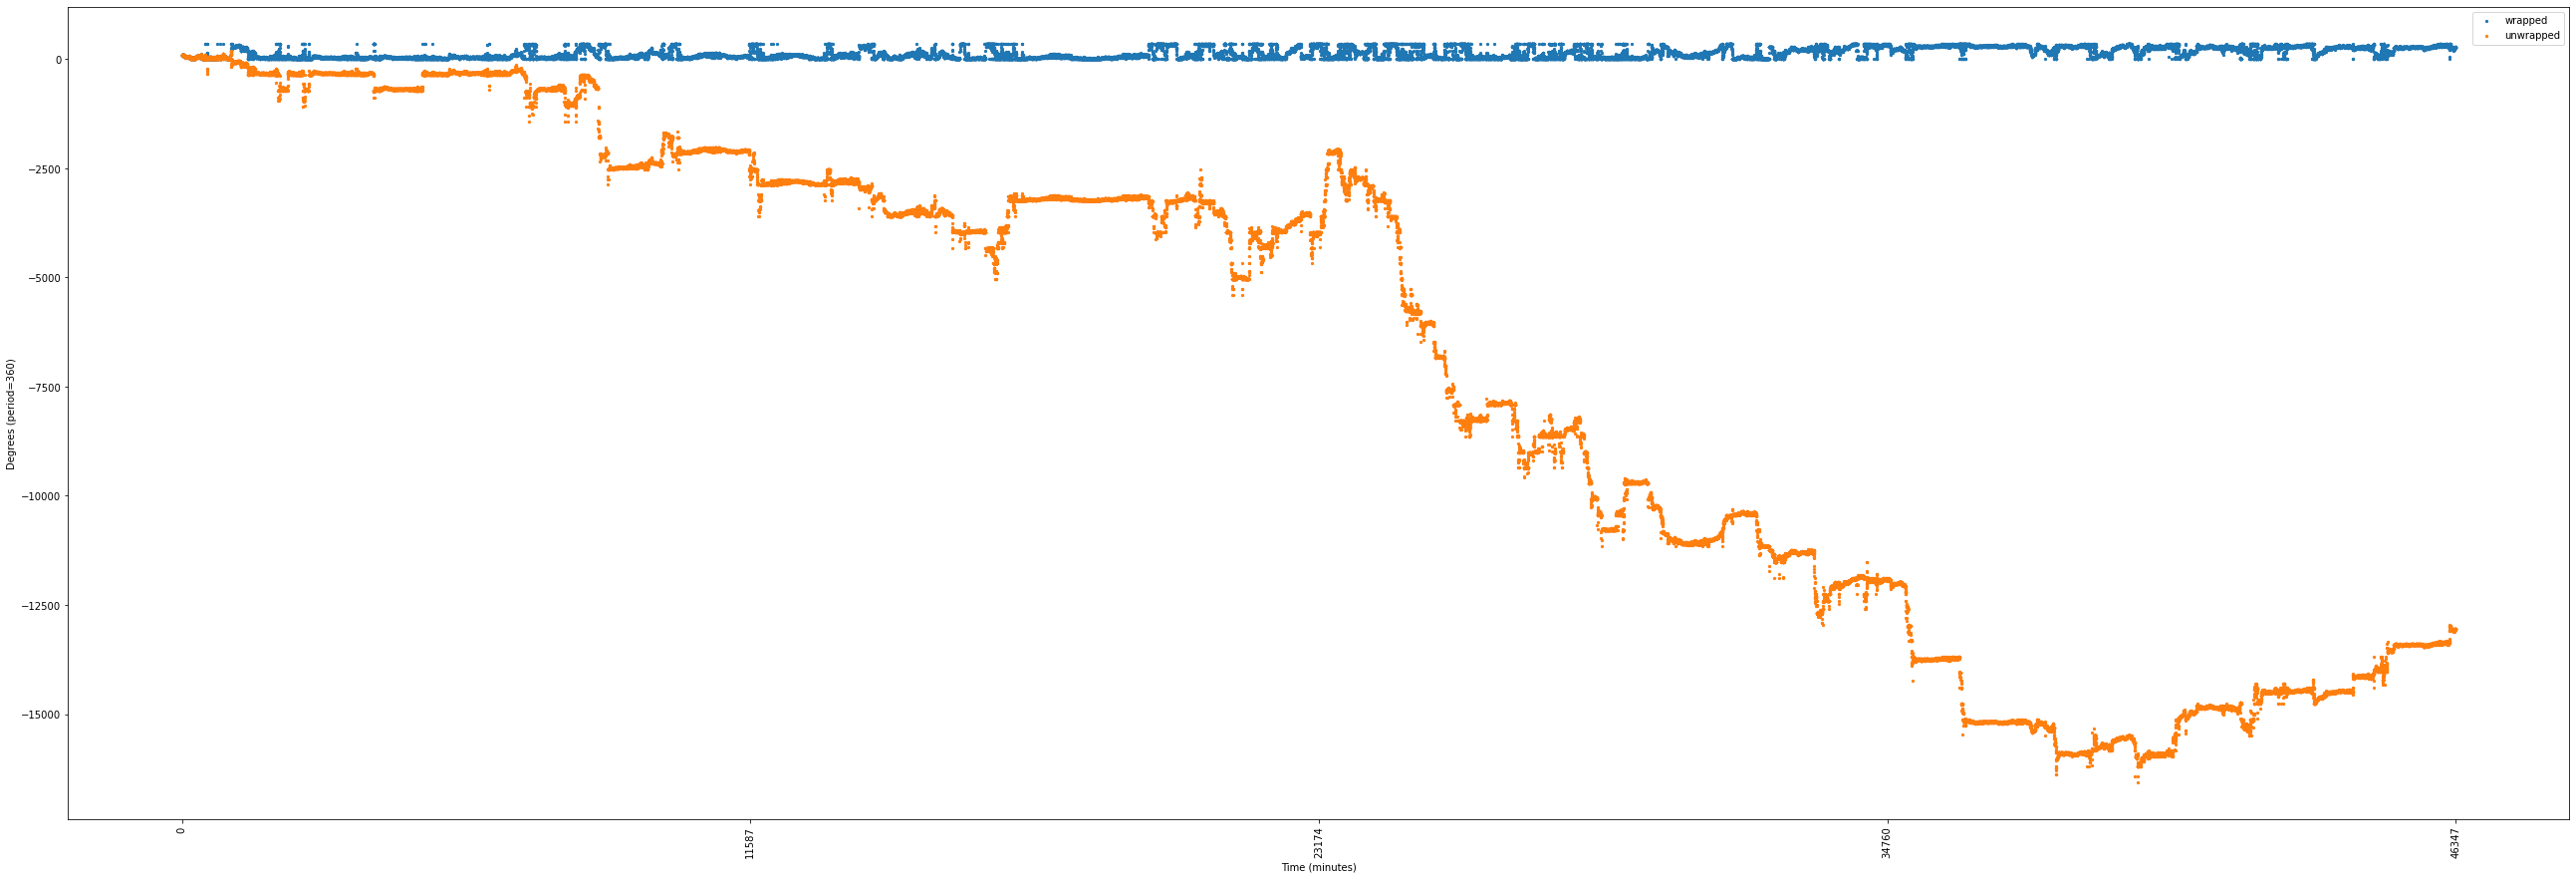

In [74]:
config = {
    'period' : 360,
    'nperseg' : 4,
    'k1' : 2,
    'k2' : 2.5,
    'k_s' : 0.25
}
wind_direction_smooth = adaptive_smoothen(wind_direction)
v4_unwrap = phase_unwrap_v4(wind_direction_smooth, **config)
# start, end = 0, len(v4_unwrap['wrapped'])
# v4_unwrap = phase_unwrap_v4(wind_direction, **config)
start, end = 0, len(v4_unwrap['wrapped'])
plot_direction(v4_unwrap, subset_keys=['wrapped','unwrapped'], start=start, end=end, s=5, plot_type='scatter', num_ticks=5, offset_start=start)

Explicitly finding clustering in unwrapped data from v3.1 using DBSCAN algorithm  
Distance metric used will be Euclidean distance between points.  
Enforcing continuous and smooth evolution of phase, first guess would be that difference in phase between 2 data points should not be more than 25 degrees, which comes to be ~25.02 units in euclidean space with y axis in units of time in minutes and x axis in units of degrees.

In [75]:
euc_dist = lambda x1, x2 : ((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2)**0.5
euc_dist([0,0],[25,1])

25.019992006393608

In [129]:
from sklearn.cluster import DBSCAN
dbscan_config = {'eps' : 25.02, 'min_samples' : 5, 'metric' : 'euclidean', 'n_jobs' : os.cpu_count()}
# dbscan_config = {'eps' : 10.02, 'min_samples' : 5, 'metric' : 'euclidean', 'n_jobs' : os.cpu_count()}
# dbscan_config = {'eps' : 5.02, 'min_samples' : 5, 'metric' : 'euclidean', 'n_jobs' : os.cpu_count()}
dbscan = DBSCAN(**dbscan_config)

In [130]:
unwrapped_data = [[phase, time] for time,phase in enumerate(v3dot1_unwrap["unwrapped"])]
dbscan.fit(unwrapped_data)

DBSCAN(eps=25.02, n_jobs=12)

In [121]:
def dbscan_plot(y, y_pred):
    
    plt.figure(figsize=(15,8))
    plt.scatter(np.arange(len(y)), y,c=y_pred, s=10, cmap='Paired')
    plt.title("DBSCAN")

In [134]:
dbscan.labels_[1300:1700]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  3, -1, -1,  3,  1,  3,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  3,  1,  3,  1,  1,  1,  1,  4,  3,  3,  3,  1,  3,
        3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4

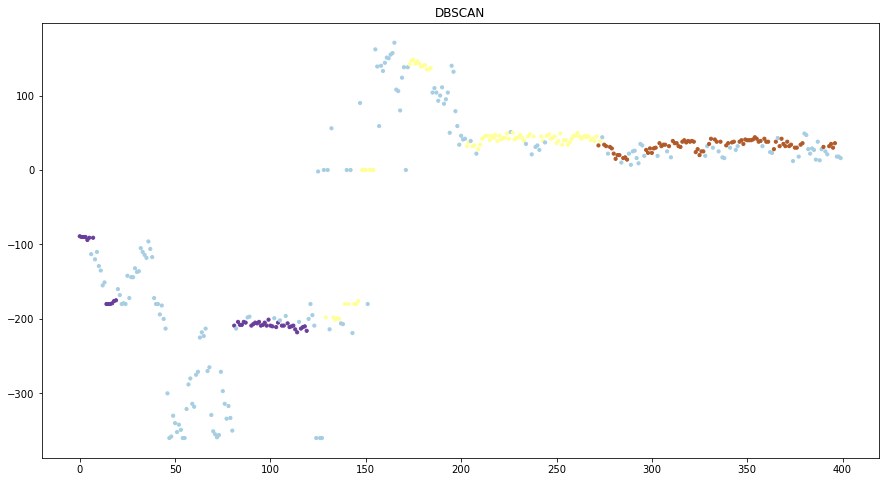

In [122]:
dbscan_plot(v3dot1_unwrap['unwrapped'][1300:1700], dbscan.labels_[1300:1700])

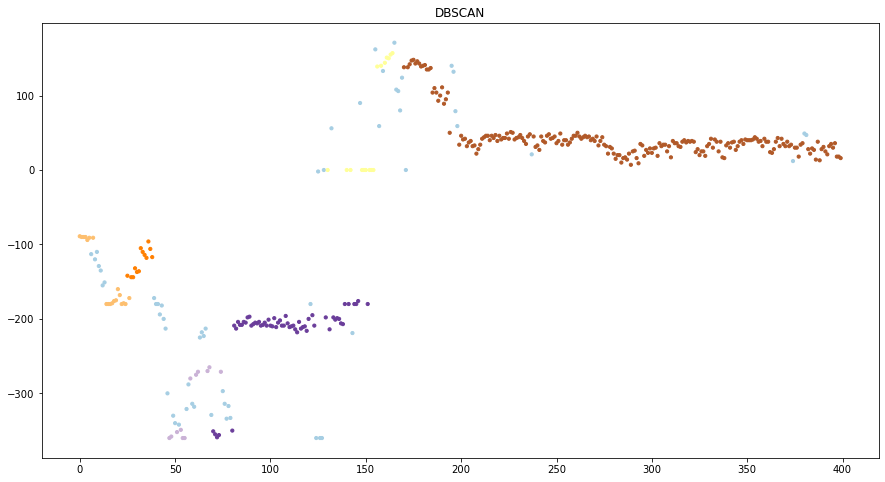

In [127]:
dbscan_plot(v3dot1_unwrap['unwrapped'][1300:1700], dbscan.labels_[1300:1700])

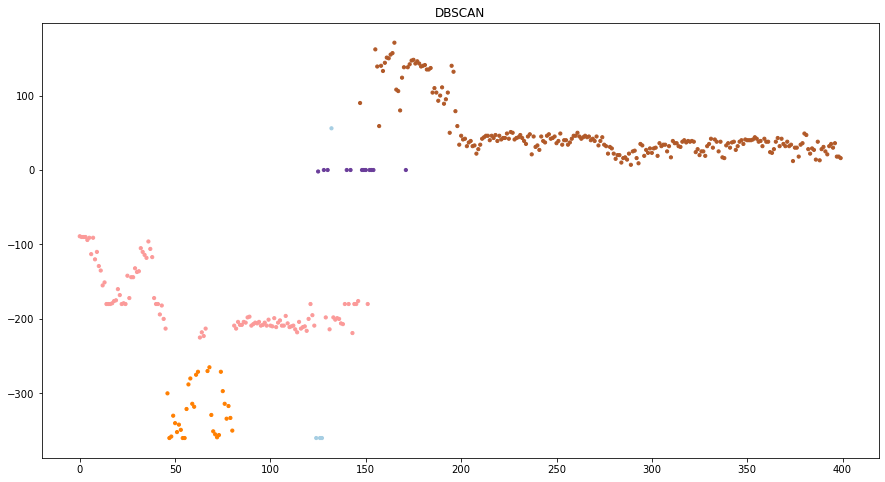

In [131]:
dbscan_plot(v3dot1_unwrap['unwrapped'][1300:1700], dbscan.labels_[1300:1700])

## Angle Interpolation at low Wind Speeds

### Wind Direction and Speed Distribution Analysis
Plotting histograms of the amount of time wind spends at a given speed or direction gives the 2 plots below.   
The wind speed distribution seems to follow a very nice statistic curve - The Weibull Distribution with k>1  
Weibull Distribution reference https://en.wikipedia.org/wiki/Weibull_distribution  
  
The wind direction distribution shows strange artifacts. The wind spends a disproportionately large amount of time at 0/360 degree angles. Assuming the device works properly this implies the following points -  
1. Most of the wind at Hingoli does indeed blow in a single direction most of the time. This is believable. But it is strange why this particular direction has to be 0 degrees. It could've been any direction. Which makes me doubtful/curious about how does the device calculate wind direction.   
2. Since average wind speed is ~3.5 with avg max wind speed ~4.5, the thought that most times wind direction is 0 degrees because no wind is blowing can be safely discarded.   
3. From the polar plot (plotted without a few powers around 0 degrees) I can easily observe that most time wind does indeed blow around the 0 degree mark. One strange artifact from here is that there is more power for angles between 0:90 than 0:-90 and suddenly there is a power spike at -90(270). The sudden spike seems a bit strange as one would expect power in nearby angles to be significant too since wind should not prefer a very specific direction within a few degrees.  


In [5]:
weather_data = pd.read_csv("weather_data_270622.csv")
weather_data.describe()

Temperature  Max Temperature  Min Temperature            RH  \
count  46352.000000     46352.000000     46352.000000  46352.000000   
mean      51.588294        51.640990        51.534058     74.609235   
std       32.789496        32.782257        32.800825     25.309611   
min        0.000000         0.000000         0.000000     18.850000   
25%       27.660000        27.680000        27.620000     53.600000   
50%       32.700000        32.750000        32.660000     79.800000   
75%      100.000000       100.000000       100.000000    100.000000   
max      100.000000       100.000000       100.000000    100.000000   

             Max RH        Min RH    Wind Speed  Max Wind Speed  \
count  46352.000000  46352.000000  46352.000000    46352.000000   
mean      74.717899     74.502739      3.408666        4.513486   
std       25.249923     25.367174      1.976712        2.459959   
min       18.970000     18.780000      0.000000        0.000000   
25%       53.800000     53.430000      1.900000        2.700000   
50%       79.940000     79.685000      3.200000        4.200000   
75%      100.000000    100.000000      4.600000        6.100000   
max      100.000000    100.000000     17.700000       21.500000   

       Wind Direction  Solar Radiation  Barometric Press.  Module Temp.  \
count    46352.000000     46352.000000       46352.000000  46352.000000   
mean       141.277831       234.122029         952.853630     32.122135   
std        127.298772       323.217853           1.924928      6.089149   
min          0.000000         0.000000         947.680000     21.470000   
25%         28.000000         0.000000         951.520000     27.550000   
50%         85.000000        22.400000         952.810000     31.180000   
75%        274.000000       424.400000         954.180000     36.092500   
max        359.000000      1307.700000         958.390000     60.000000   

               Rain  Battery Voltage  
count  46352.000000     46352.000000  
mean       0.003827        12.926562  
std        0.098978         0.387905  
min        0.000000        12.500000  
25%        0.000000        12.600000  
50%        0.000000        12.700000  
75%        0.000000        13.300000  
max       15.200000        13.800000

In [31]:
wind_direction = np.array(weather_data['Wind Direction'].copy(deep=True).tolist())
wind_speed = np.array(weather_data['Wind Speed'].copy(deep=True).tolist())
max_wind_speed = np.array(weather_data['Max Wind Speed'].copy(deep=True).tolist())

In [6]:
weather_data['Wind Speed'].apply(lambda x : x<3.41-3.96 or x>3.41+3.96).sum()/weather_data.shape[0]

0.03820762858129099

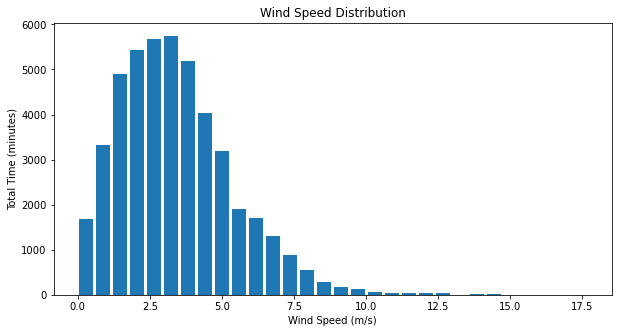

In [13]:
plt.figure(0, figsize=(10,5))
hist = np.histogram(weather_data['Wind Speed'], bins=30)
bins = hist[1]
bins = (bins[1:]+bins[:-1])/2
plt.bar(bins, hist[0], width=0.5)
plt.title("Wind Speed Distribution")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Total Time (minutes)")
plt.show()

In [ ]:
N = 80
bottom = 8
max_height = 4

theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = max_height*np.random.rand(N)
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)

plt.show()

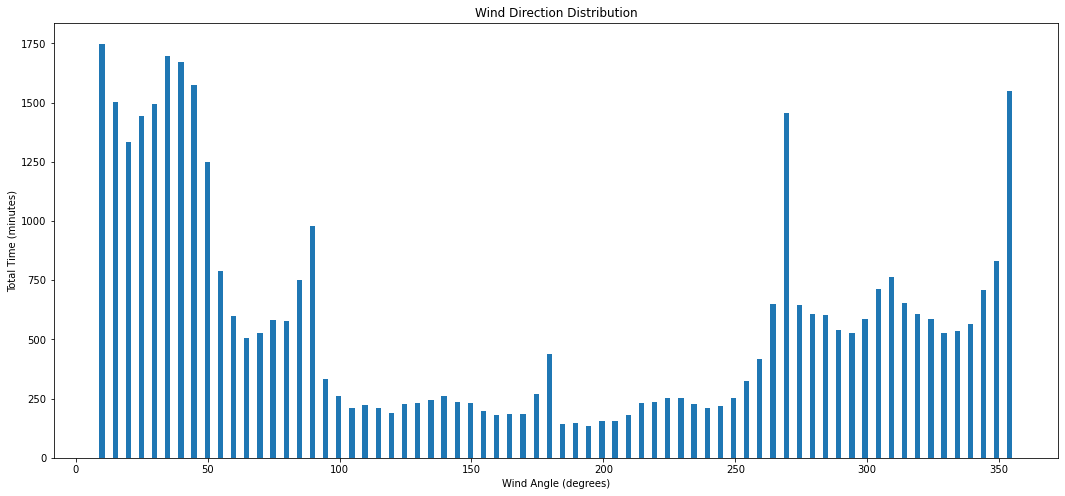

In [53]:
plt.figure(1, figsize=(18,8))
hist = np.histogram(weather_data['Wind Direction'], bins=72)
plt.bar(hist[1][2:-1], hist[0][2:], width=2)
plt.title('Wind Direction Distribution')
plt.xlabel('Wind Angle (degrees)')
plt.ylabel('Total Time (minutes)')
plt.show()

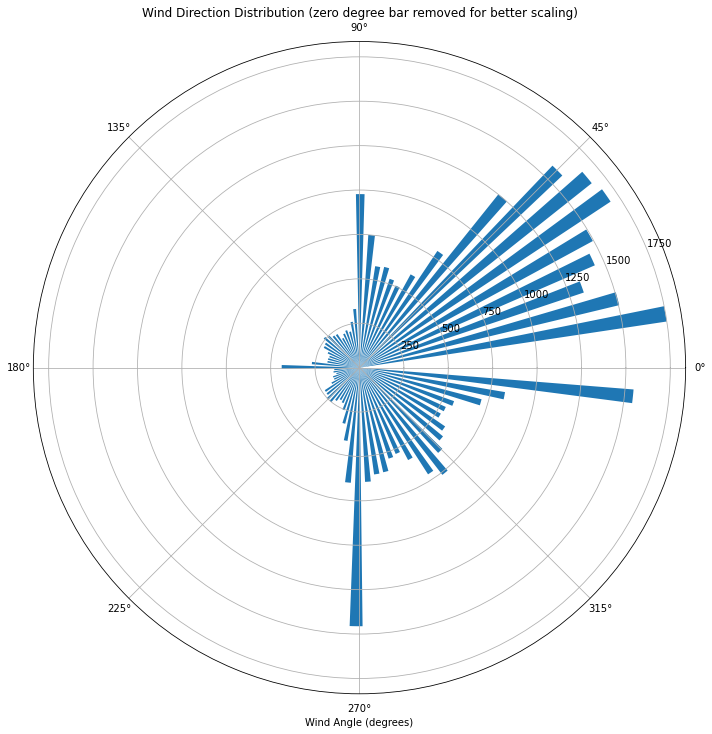

In [66]:
fig = plt.figure(1, figsize=(12,12))
ax = fig.add_subplot(111, polar=True, )
hist = np.histogram(weather_data['Wind Direction'], bins=72)
ax.bar(np.deg2rad(hist[1][2:-1]), hist[0][2:], width=0.05)
plt.title('Wind Direction Distribution (zero degree bar removed for better scaling)')
plt.xlabel('Wind Angle (degrees)')
plt.show()

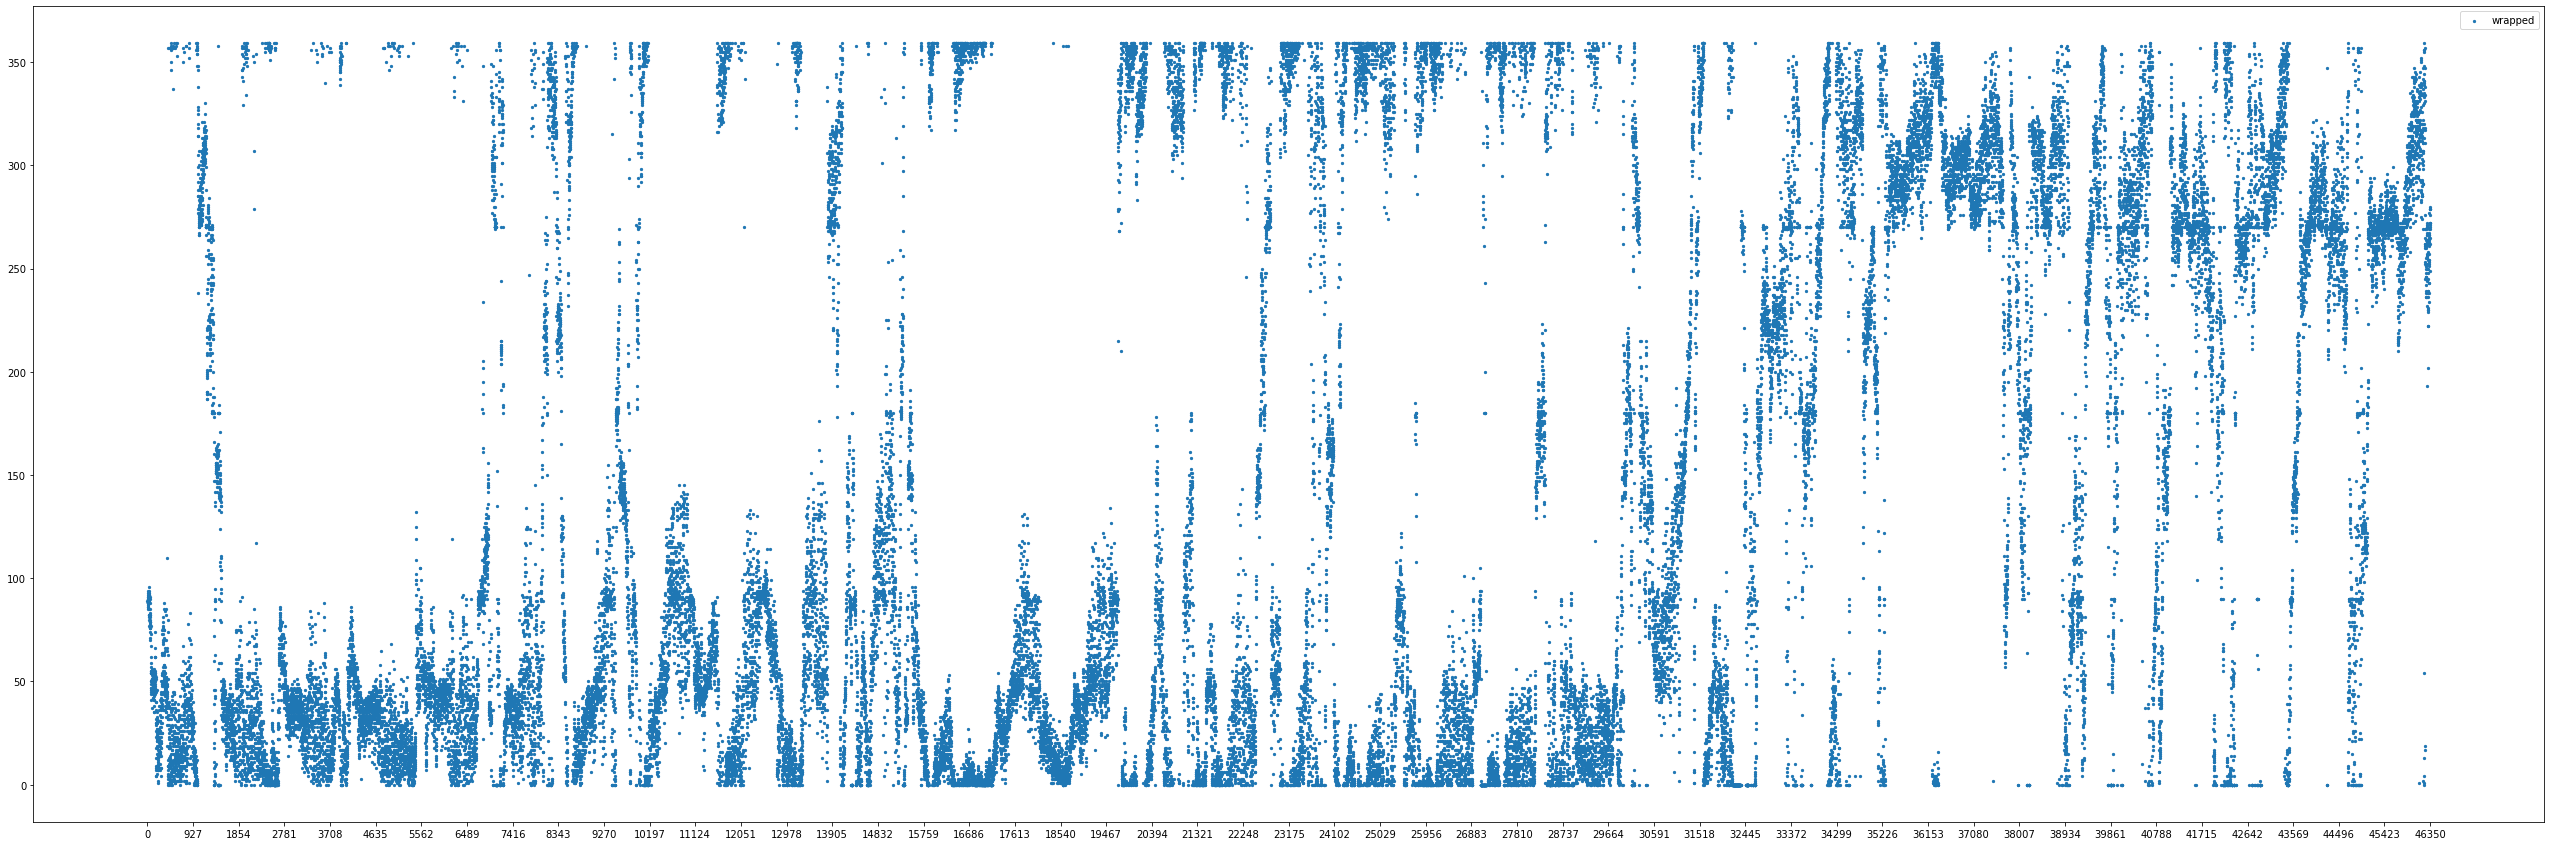

In [346]:
plot_direction({'wrapped':wind_direction})

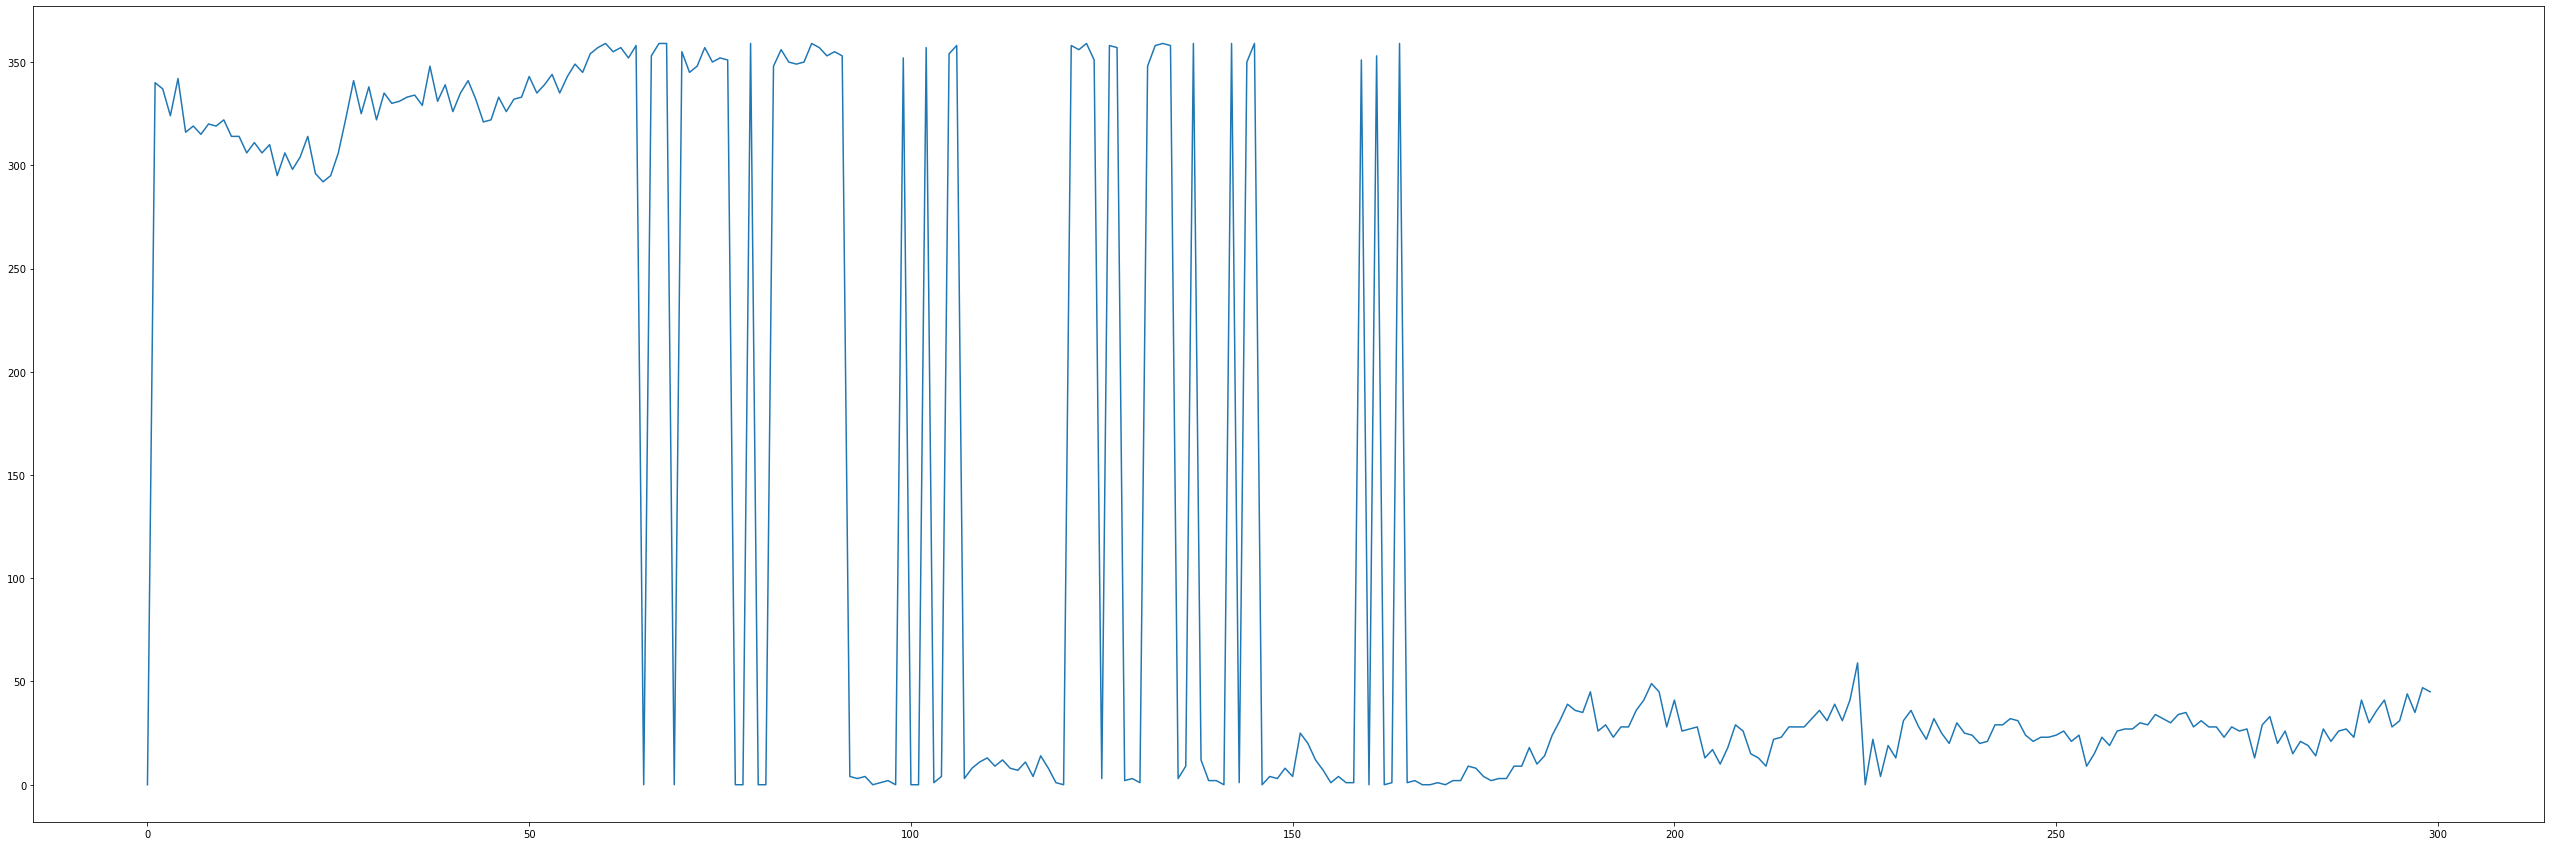

In [351]:
plt.figure(figsize=(45,15))
plt.plot(np.arange(300), wind_direction[10000:10300])

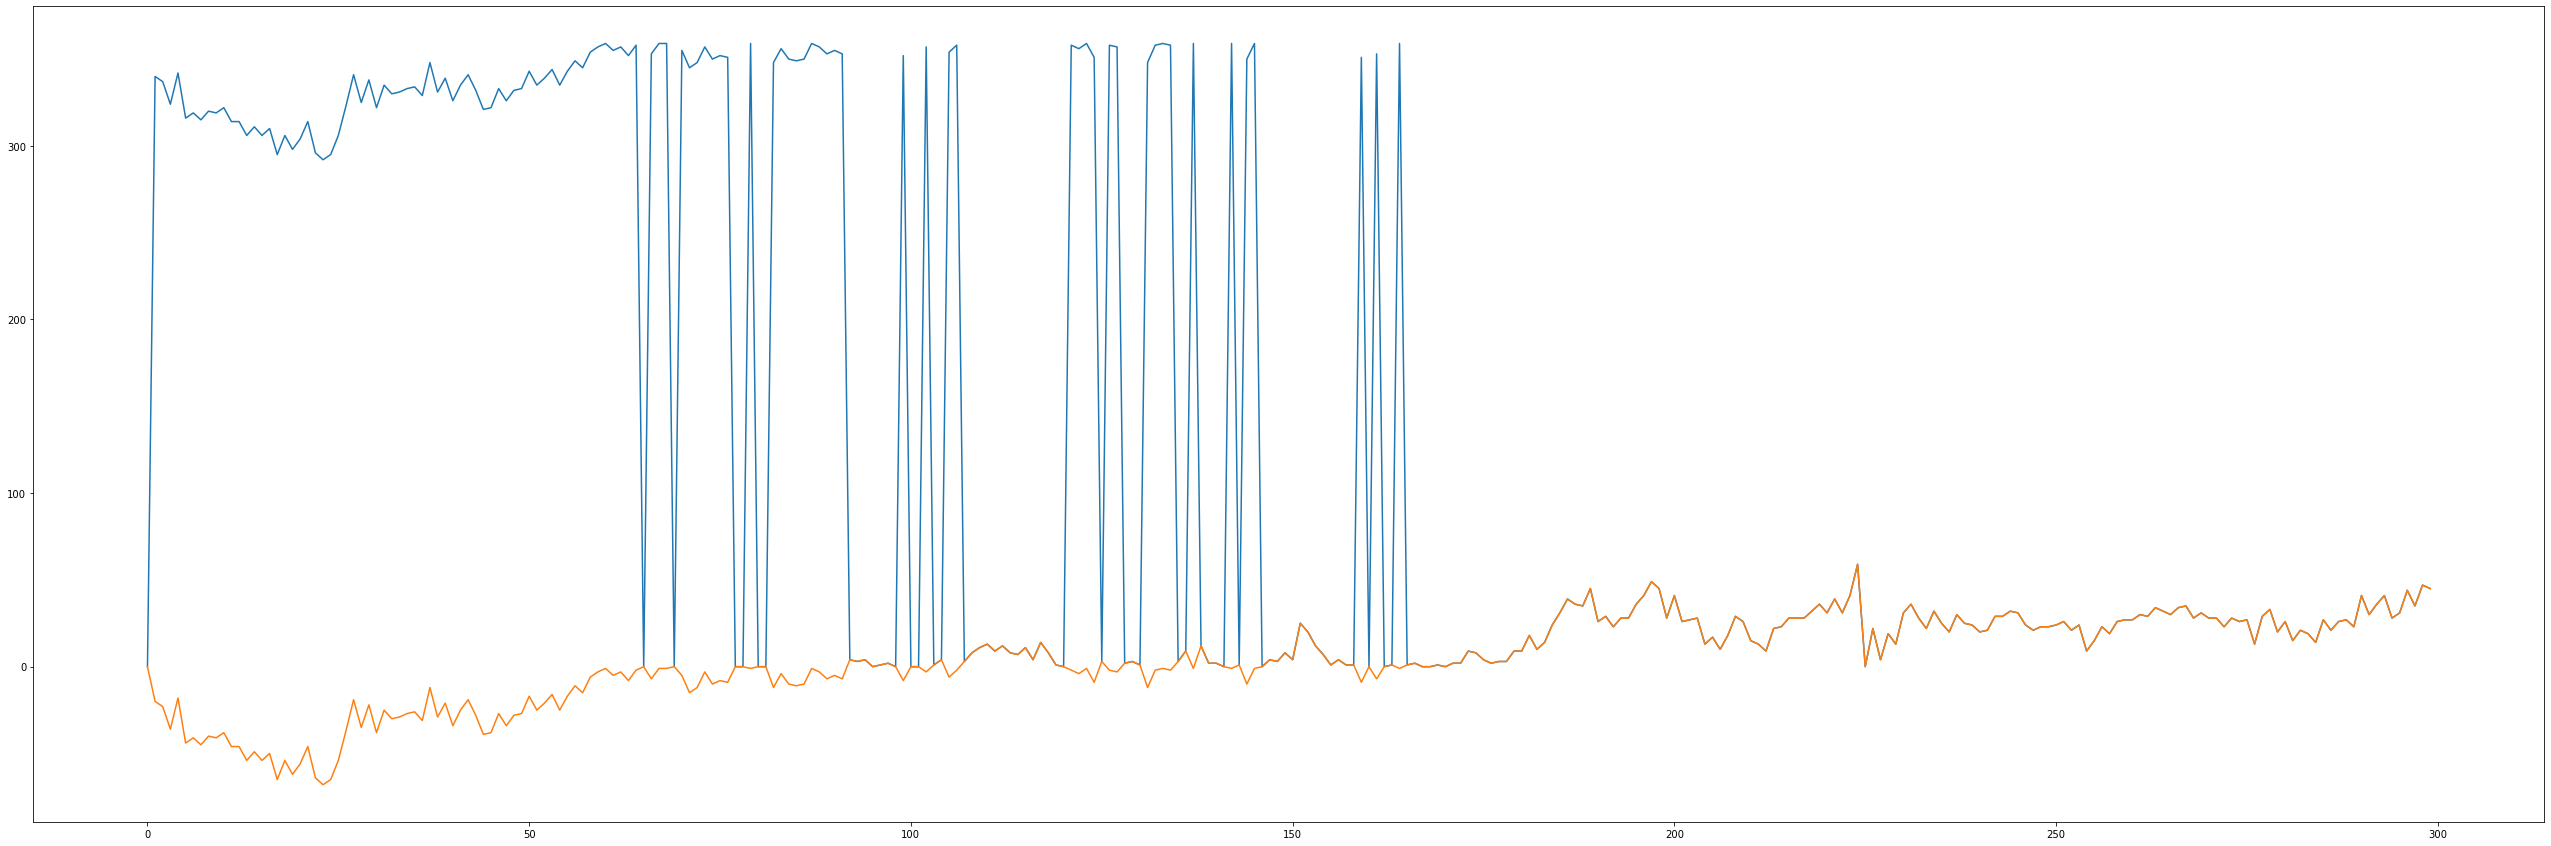

In [352]:
wind_dir2 = []
for d in wind_direction:
    if d>=180:
        wind_dir2.append(d-360)
    else:
        wind_dir2.append(d)
    
plt.figure(figsize=(45,15))
plt.plot(np.arange(300), wind_direction[10000:10300])
plt.plot(np.arange(300), wind_dir2[10000:10300])

In [35]:
wind_data.columns = wind_data.iloc[0]
wind_data2.columns = wind_data2.iloc[0]

In [38]:
wind_data = wind_data[2:]

wind_data['Date'] = pd.to_datetime(wind_data['Date'])

wind_data2 = wind_data2[2:]
wind_data2['Date'] = pd.to_datetime(wind_data2['Date'])

/var/folders/m3/s781kkx53mxbh7vj9g_h4xwh0000gp/T/ipykernel_51641/2603226621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_data['Date'] = pd.to_datetime(wind_data['Date'])


In [44]:
overlap = wind_data.loc[wind_data['Date'].isin(wind_data2['Date'].tolist())]

In [45]:
overlap.head()

0           Date      Time Temperature Max Temperature Min Temperature     RH  \
28614 2022-06-15  00:00:00       27.14           27.15            27.1  79.78   
28615 2022-06-15  00:01:00       27.14           27.15           27.09  79.78   
28616 2022-06-15  00:02:00        27.1           27.15           27.09  79.77   
28617 2022-06-15  00:03:00       27.13           27.17           27.09  79.76   
28618 2022-06-15  00:04:00       27.13           27.14           27.09  79.73   

0     Max RH Min RH Wind Speed Max Wind Speed Wind Direction Solar Radiation  \
28614  79.81  79.75        2.3            3.2             15               0   
28615  79.81  79.73        2.6              3              2               0   
28616   79.8  79.73        2.6              3              3               0   
28617  79.79  79.73          2              3              3               0   
28618  79.79  79.73        2.7              3            359               0   

0     Barometric Press. Module Temp. Rain Battery Voltage  \
28614            954.58        27.16    0            12.6   
28615            954.56        27.16    0            12.5   
28616            954.54        27.16    0            12.5   
28617            954.53        27.18    0            12.5   
28618            954.52        27.16    0            12.5   

0                 GMT Time       NaN  
28614  2022-06-14 00:00:00  18:30:00  
28615  2022-06-14 00:00:00  18:31:00  
28616  2022-06-14 00:00:00  18:32:00  
28617  2022-06-14 00:00:00  18:33:00  
28618  2022-06-14 00:00:00  18:34:00

In [48]:
overlap2 = wind_data2.loc[wind_data2['Date'].isin(overlap['Date'].tolist())]

In [49]:
overlap.shape, overlap2.shape

((17740, 18), (17449, 18))

In [51]:
overlap.Date.describe()

/var/folders/m3/s781kkx53mxbh7vj9g_h4xwh0000gp/T/ipykernel_51641/905145588.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  overlap.Date.describe()


count                   17740
unique                     13
top       2022-06-15 00:00:00
freq                     1440
first     2022-06-15 00:00:00
last      2022-06-27 00:00:00
Name: Date, dtype: object

In [52]:
overlap2.Date.describe()

/var/folders/m3/s781kkx53mxbh7vj9g_h4xwh0000gp/T/ipykernel_51641/102343445.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  overlap2.Date.describe()


count                   17449
unique                     13
top       2022-06-16 00:00:00
freq                     1440
first     2022-06-15 00:00:00
last      2022-06-27 00:00:00
Name: Date, dtype: object

In [43]:
overlap.merge(wind_data2, on="Date", how="left")

KeyboardInterrupt: 